# Analytics - Product Quality

#### Date: 2024/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2024/02
##### Professor: Hilmer Neri

##### Members:

- André Corrêa
- Gabriel Mariano
- Gabriel Costa
- Levi Queiroz
- Daniel Rodrigues
- Danilo de Melo
- Dylan Portela
- Isabella Choukaira
- João Filipe
- Marina Galdi
- Ricardo Henrique
- Yasmin Moreira


### LIBRARIES

In [2]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [3]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [5]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2024.2-ARANDU-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'APP': 'dart',
    'Frontend': 'ts',
    'UserService': 'ts',
    'StudioMaker': 'ts',
}

### SonarCloud
##### Path to the folder with all your jsons

In [6]:
# Maybe you should change this path to your own path

sonar_files = glob('../analytics-raw-data/fga-eps-mds-*.json')

## Create DataFrame

#### Unmarshall json

In [7]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [9]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [10]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [11]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [12]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[5]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [13]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

array(['fga-eps-mds-2024.2-ARANDU-APP',
       'fga-eps-mds-2024.2-ARANDU-Frontend',
       'fga-eps-mds-2024.2-ARANDU-StudioMaker',
       'fga-eps-mds-2024.2-ARANDU-UserService'], dtype=object)

### Create dataframe per repository

In [14]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [15]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [16]:
def complexity(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [17]:
def comments(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [18]:
def duplication(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [19]:
def test_success(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [20]:
def fast_tests(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [21]:
def coverage(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [22]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(complexity(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(comments(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(duplication(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(test_success(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(fast_tests(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(coverage(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'complexity': m1_list,
        'comments': m2_list,
        'duplication': m3_list,
        'test_success': m4_list,
        'fast_tests': m5_list,
        'coverage': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [23]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

/tmp/ipykernel_119743/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_119743/1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uts_df = uts_df.fillna(0)
/tmp/ipykernel_119743/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_119743/1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. 

## Data visualization

In this area you will need to plot the metrics of each repository.

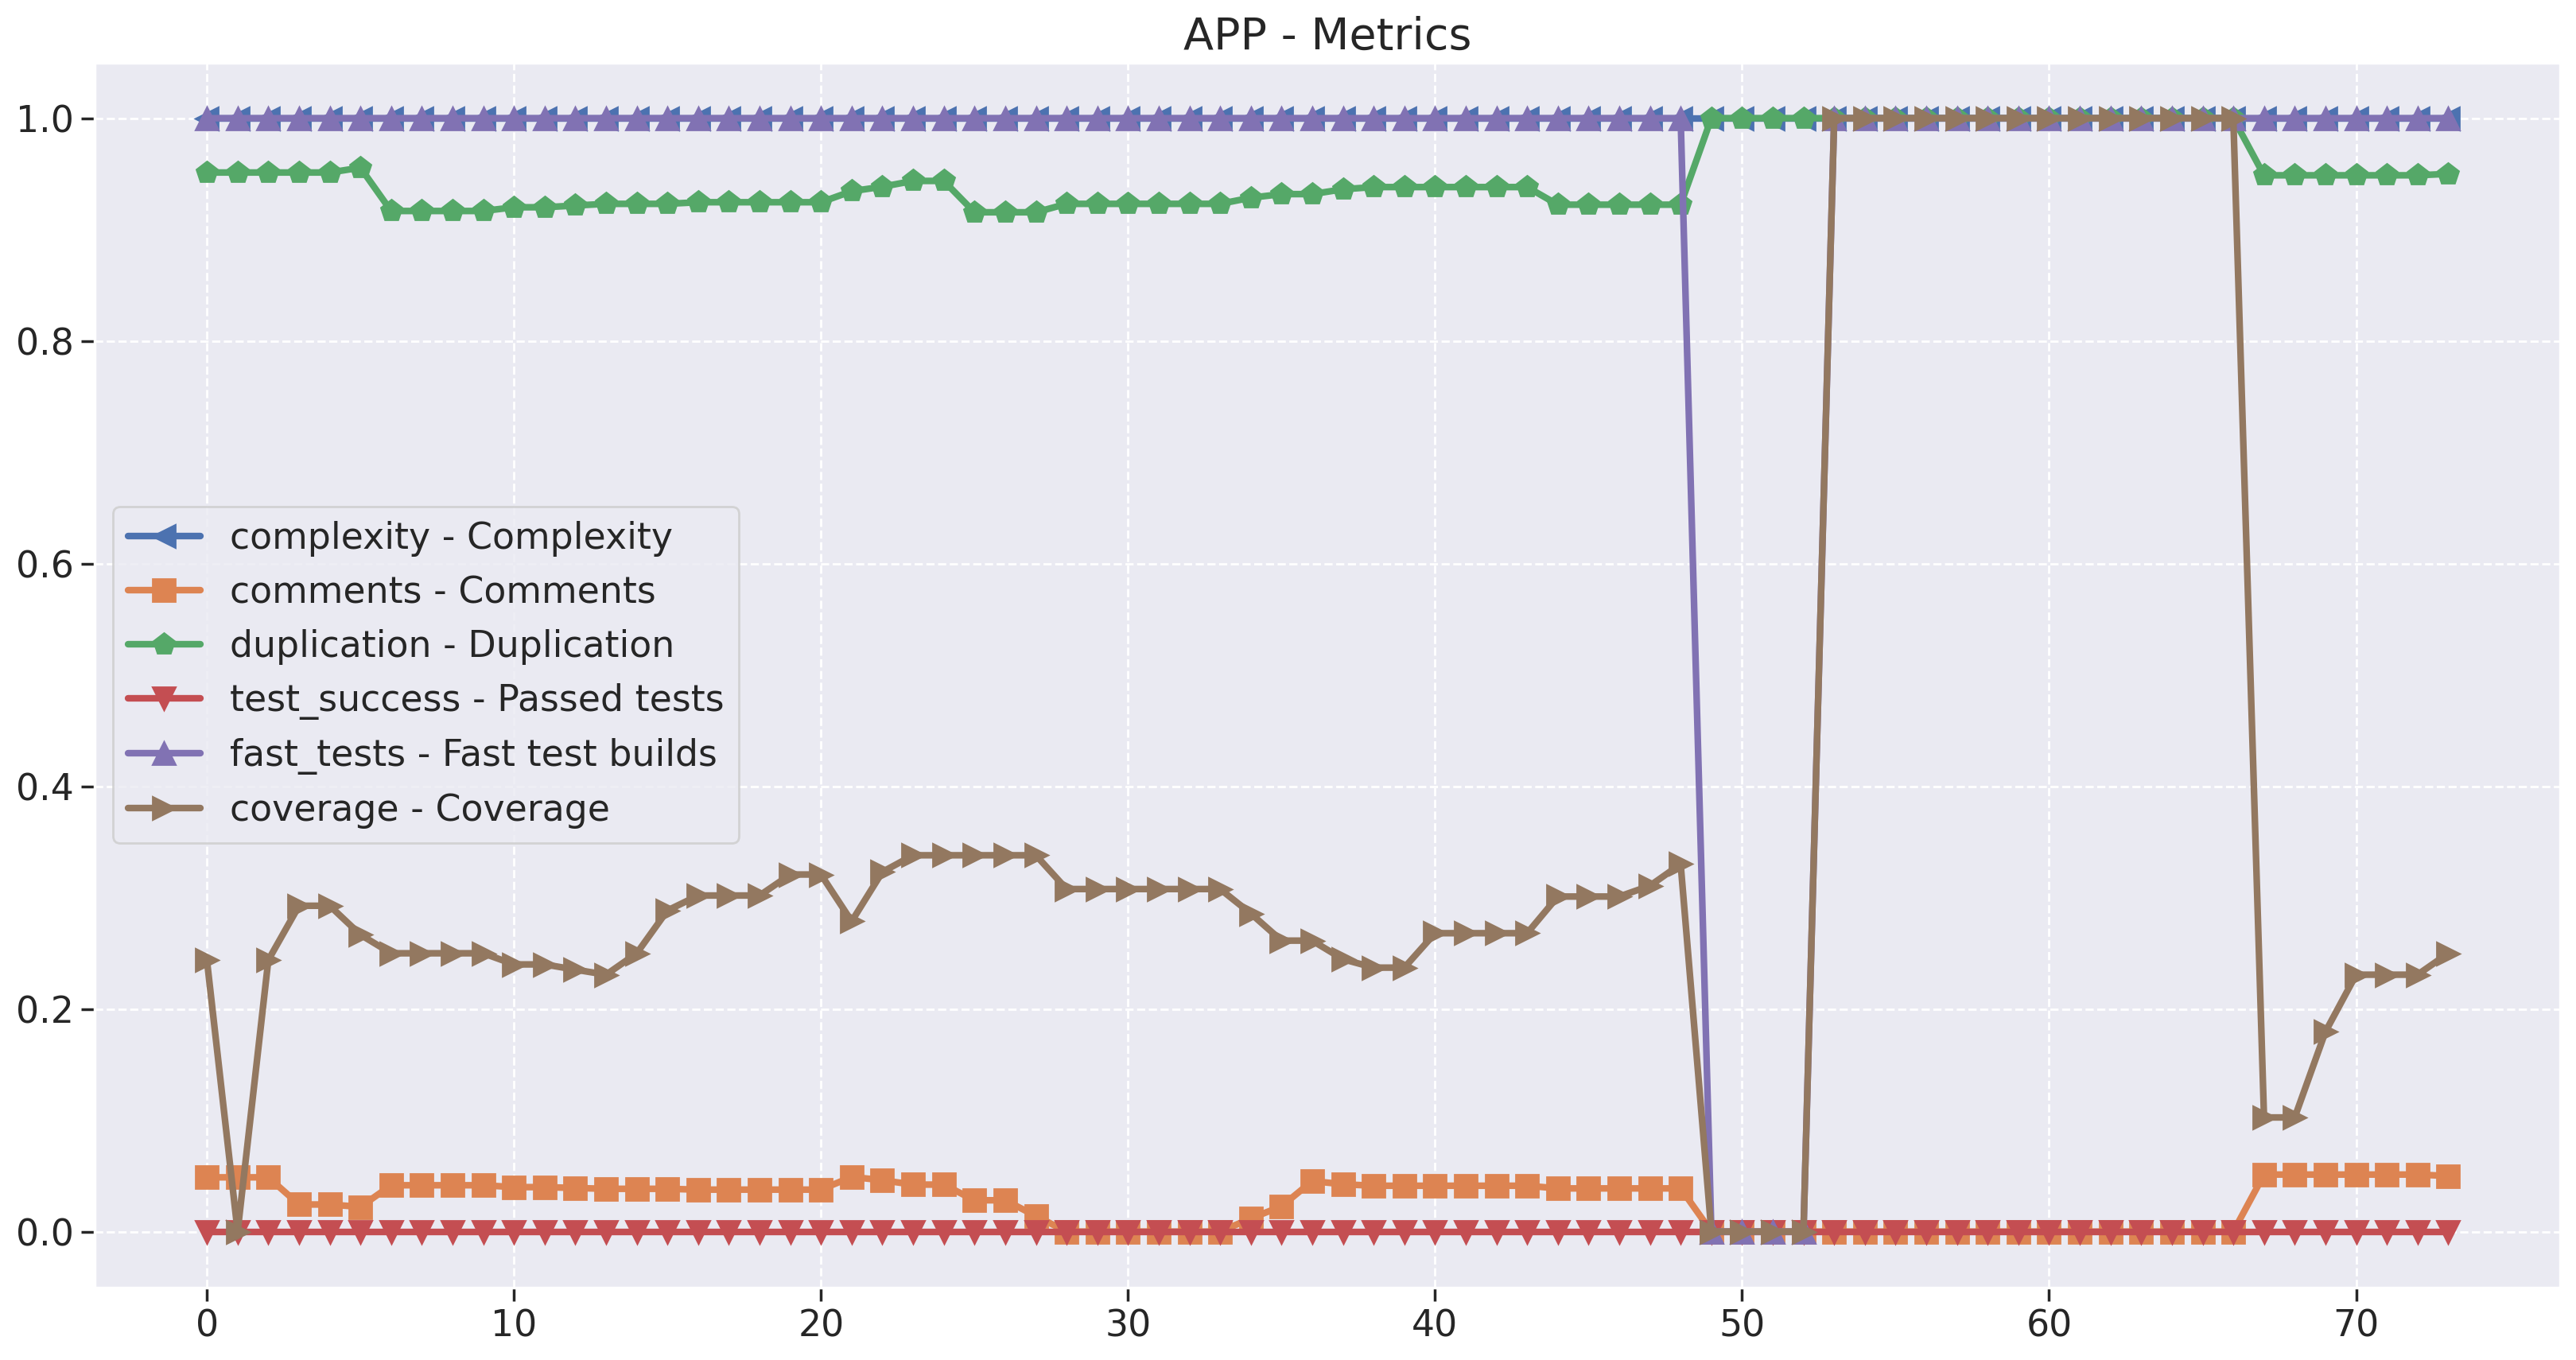

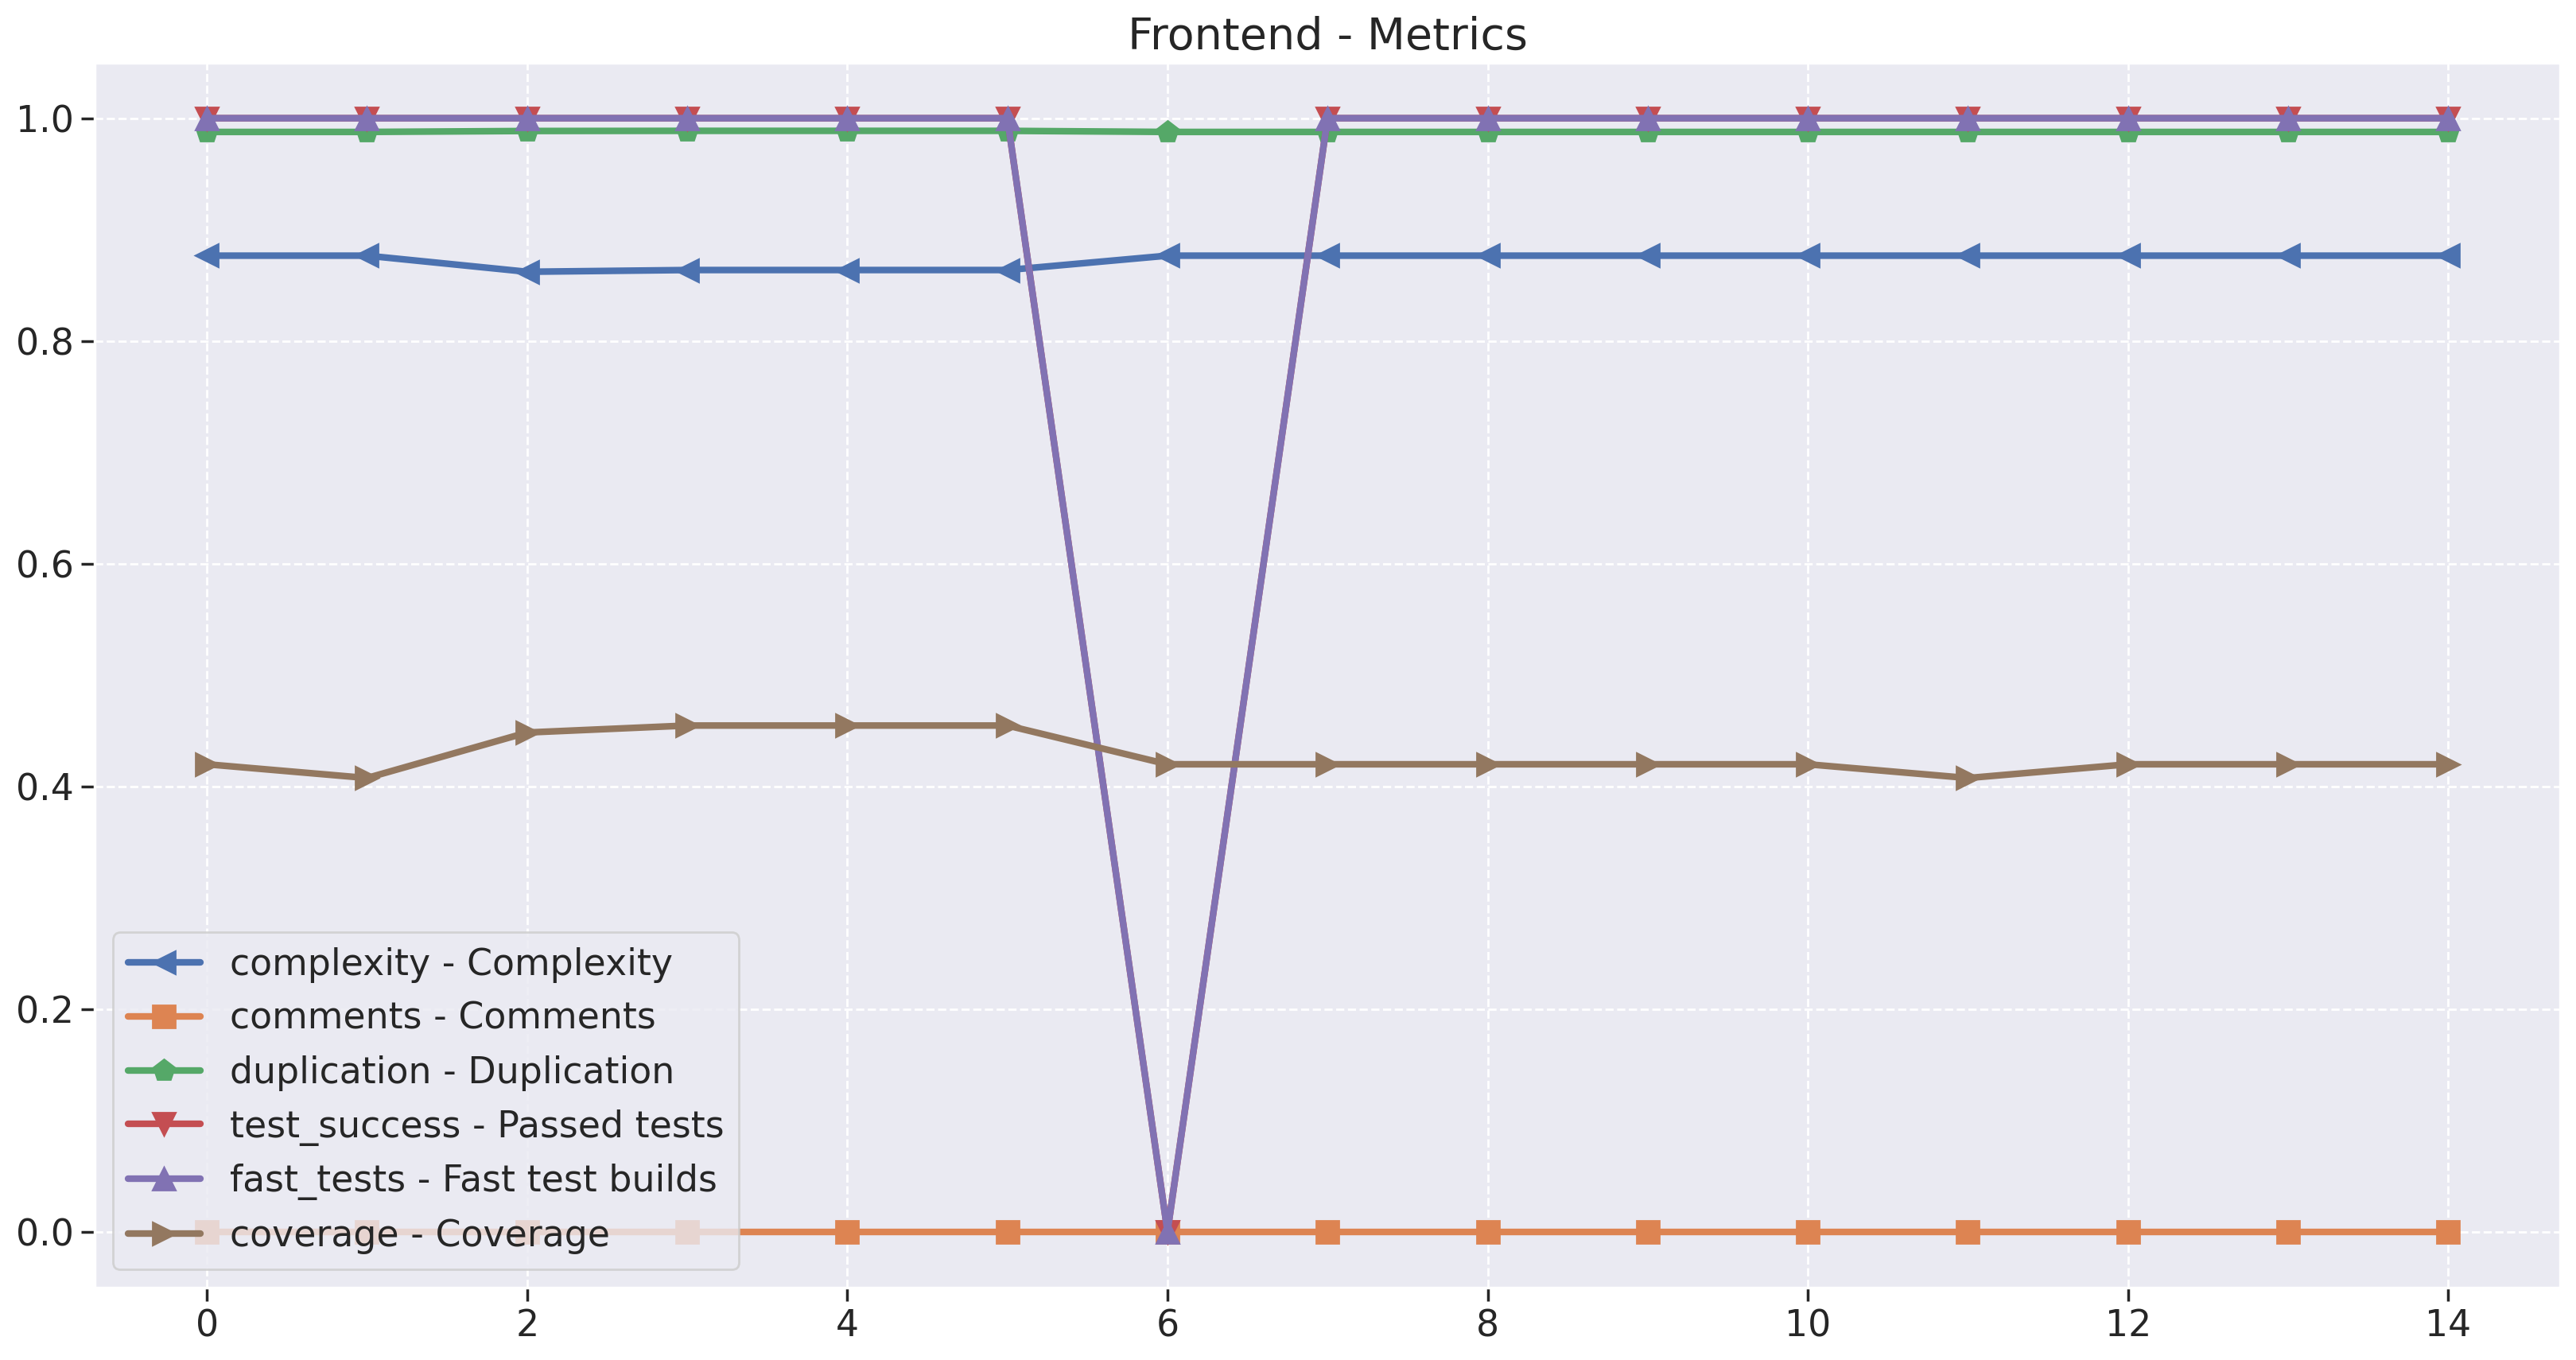

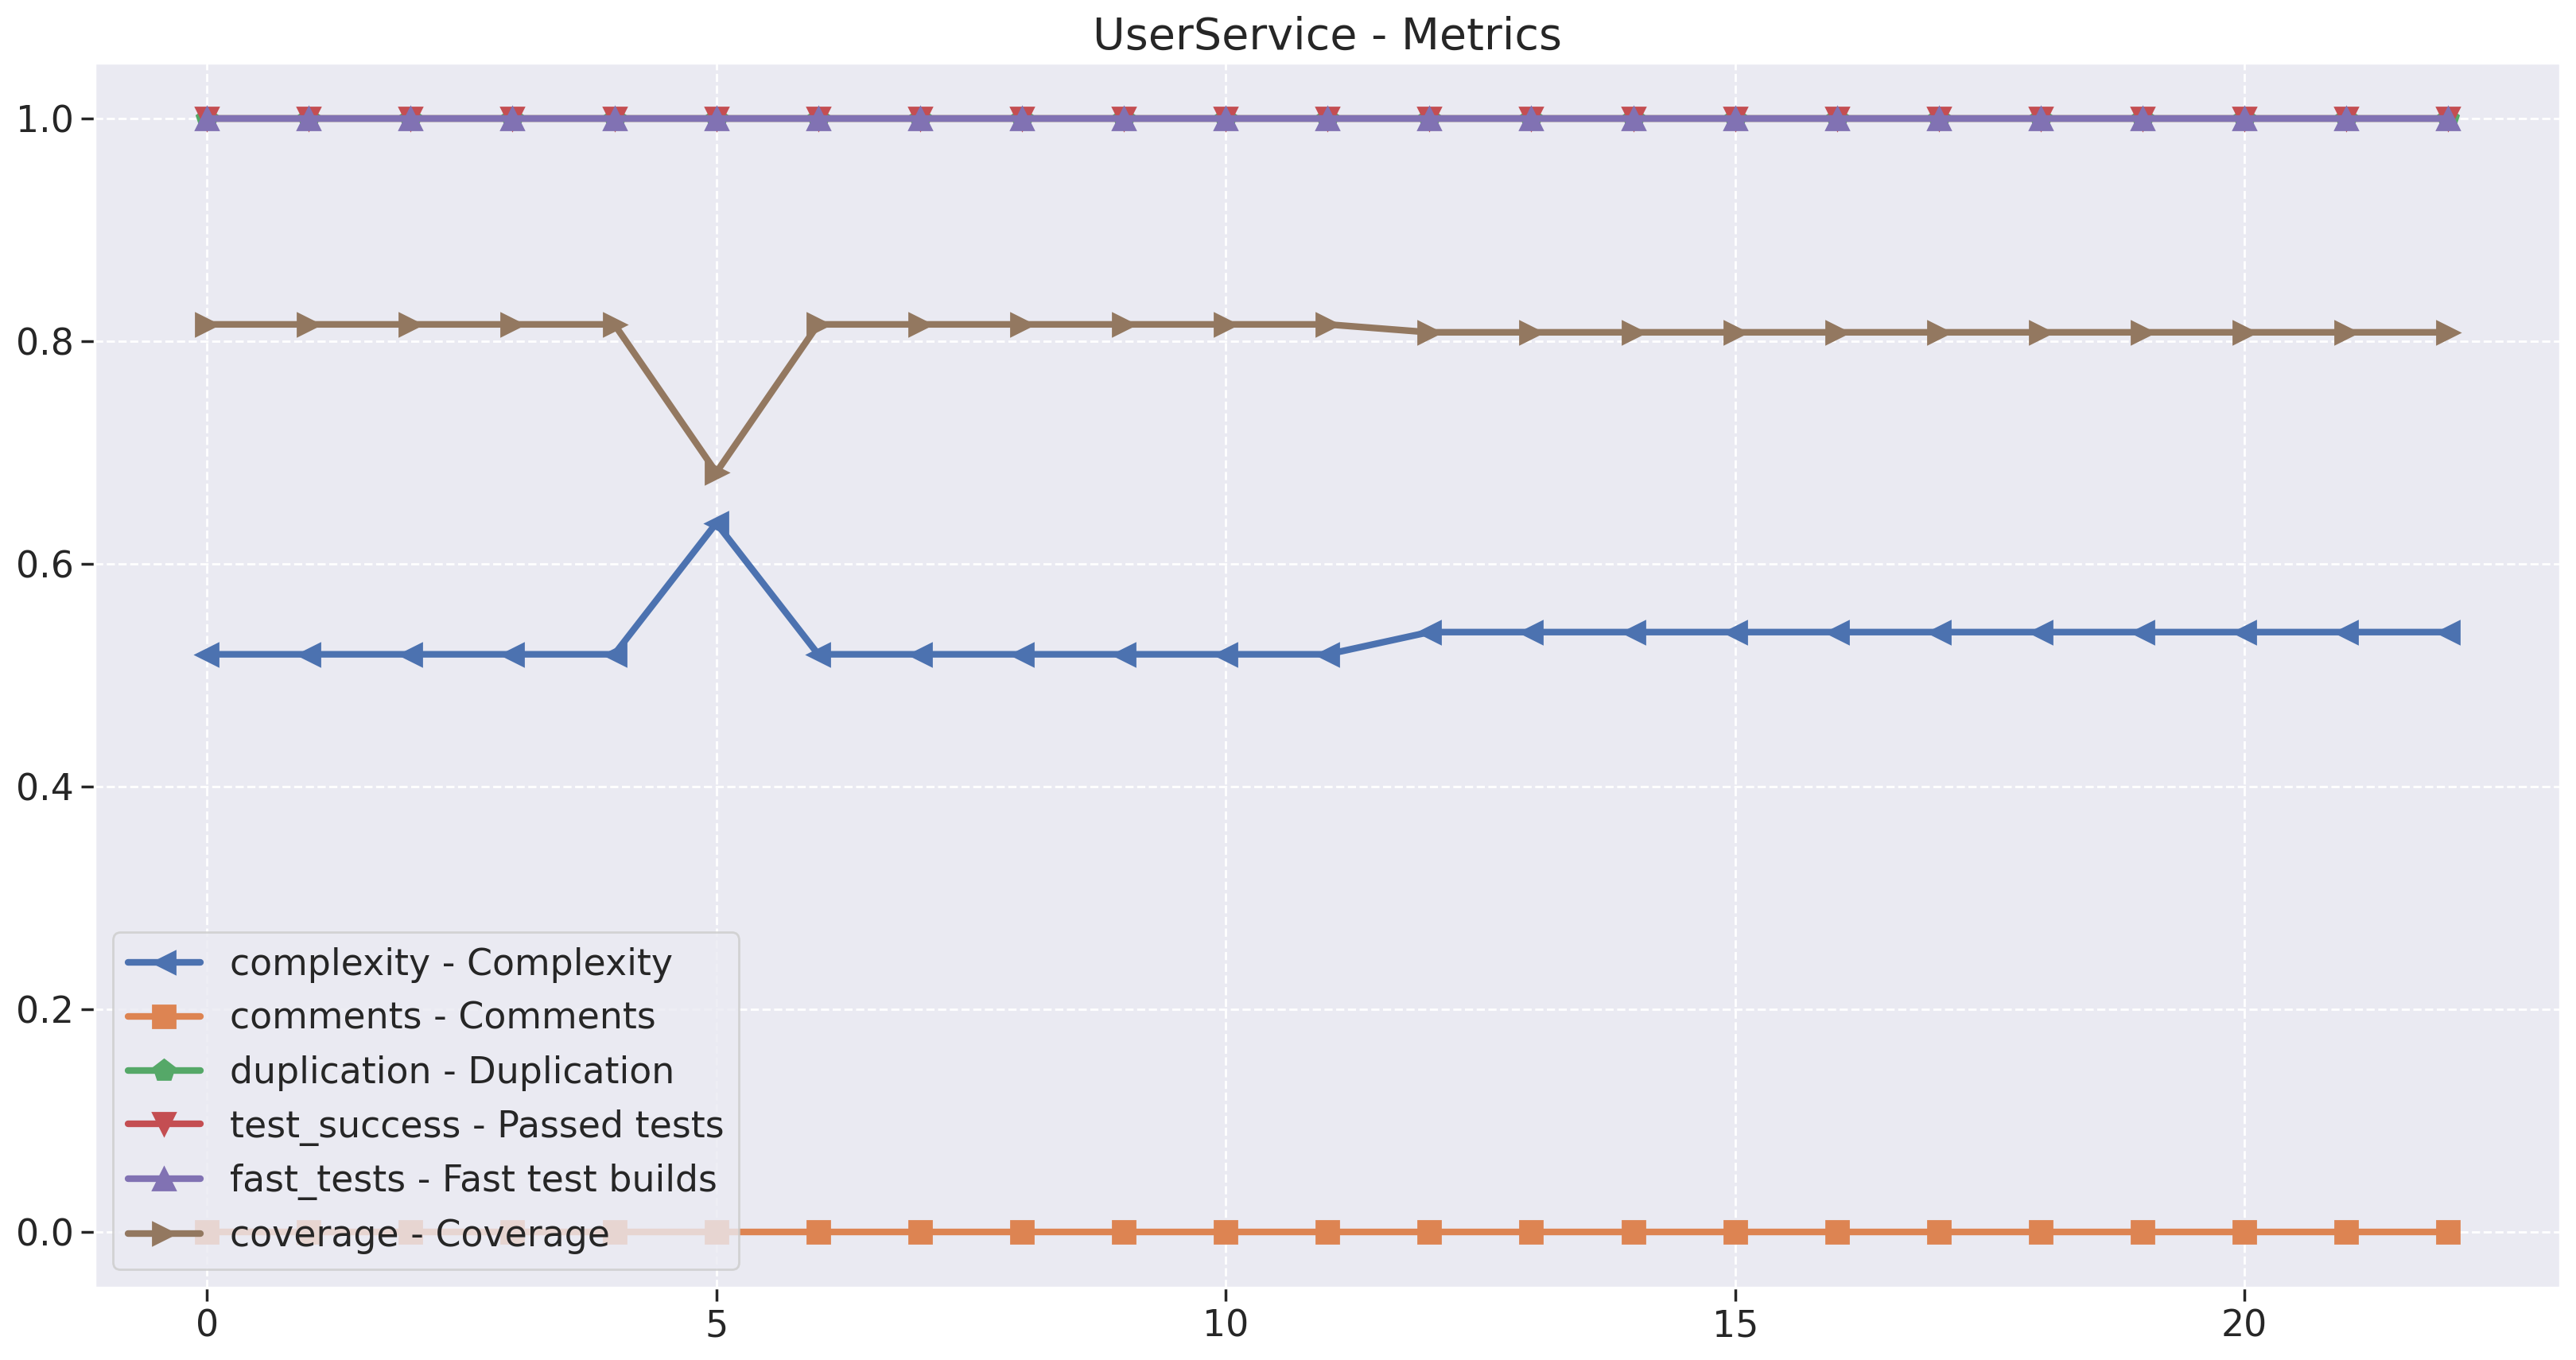

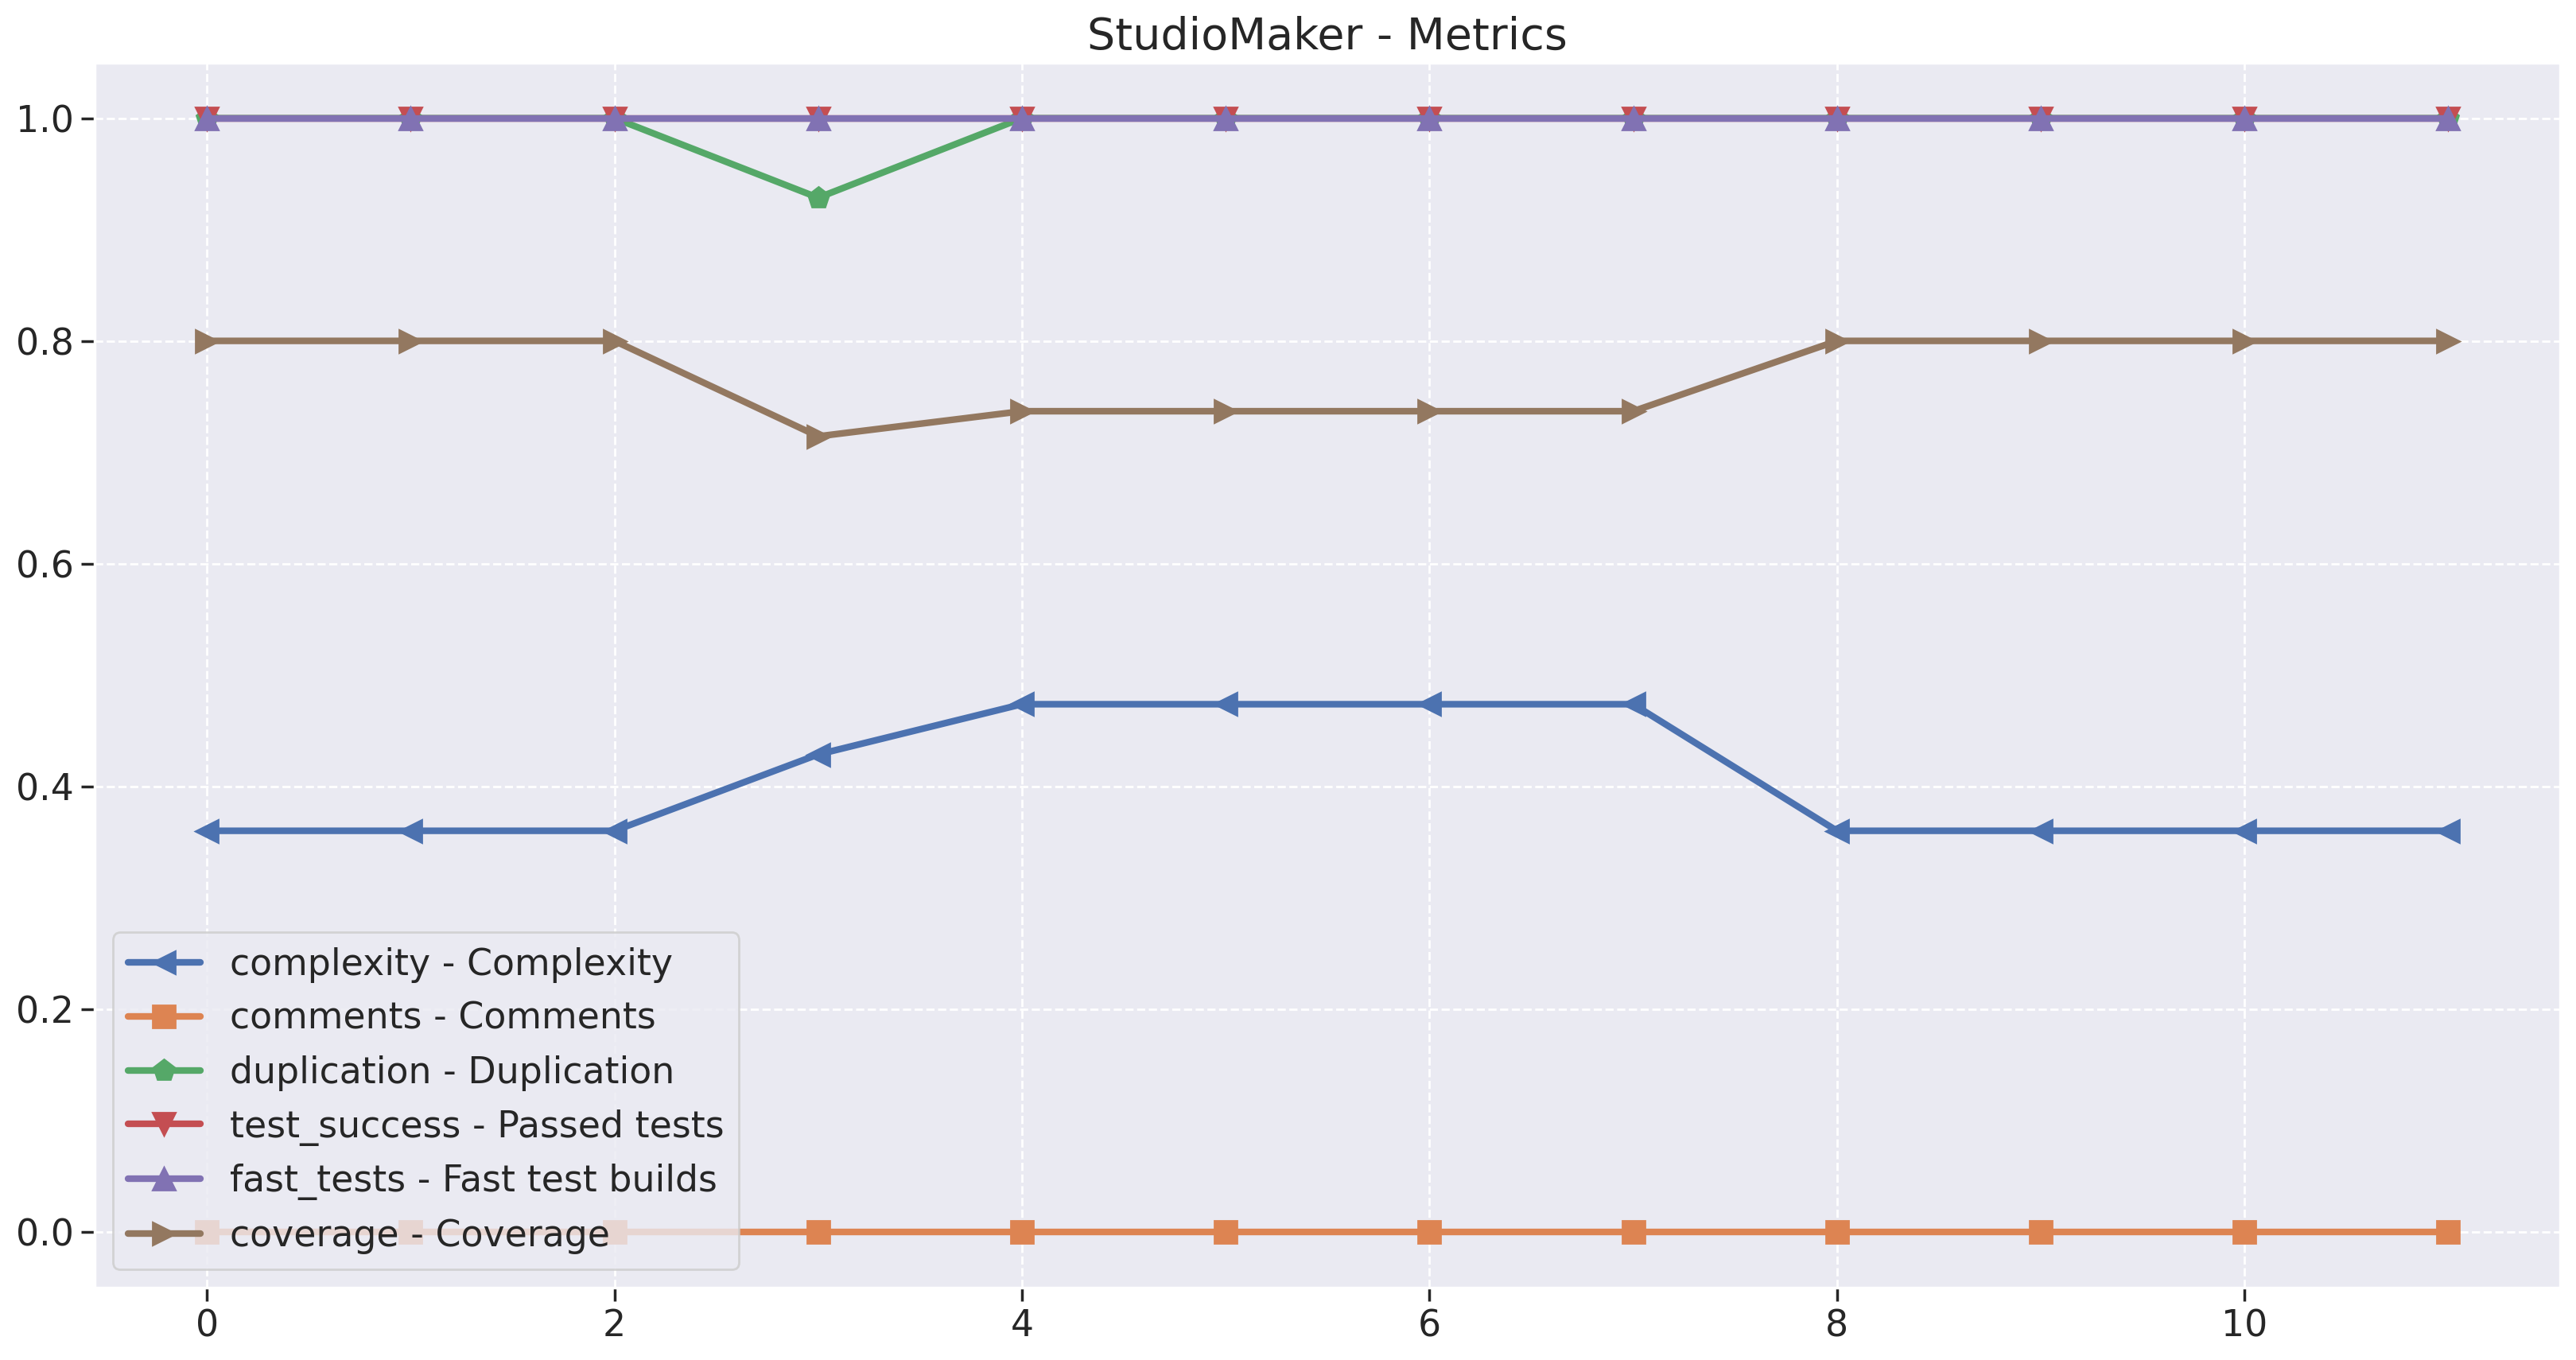

In [24]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['complexity'], linewidth=3, marker='<', markersize=10, label="complexity - Complexity")
    plt.plot(data['comments'], linewidth=3, marker='s', markersize=10, label="comments - Comments")
    plt.plot(data['duplication'], linewidth=3, marker='p', markersize=10, label="duplication - Duplication")
    plt.plot(data['test_success'], linewidth=3, marker='v', markersize=10, label="test_success - Passed tests")
    plt.plot(data['fast_tests'], linewidth=3, marker='^', markersize=10, label="fast_tests - Fast test builds")
    plt.plot(data['coverage'], linewidth=3, marker='>', markersize=10, label="coverage - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [25]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['complexity']*pm1) + (data['comments']*pm2) + (data['duplication']*pm3)) * psc1
    data['testing_status'] = ((data['test_success']*pm4) + (data['fast_tests']*pm5) + (data['coverage']*pm6)) * psc2

### Code Quality visualization

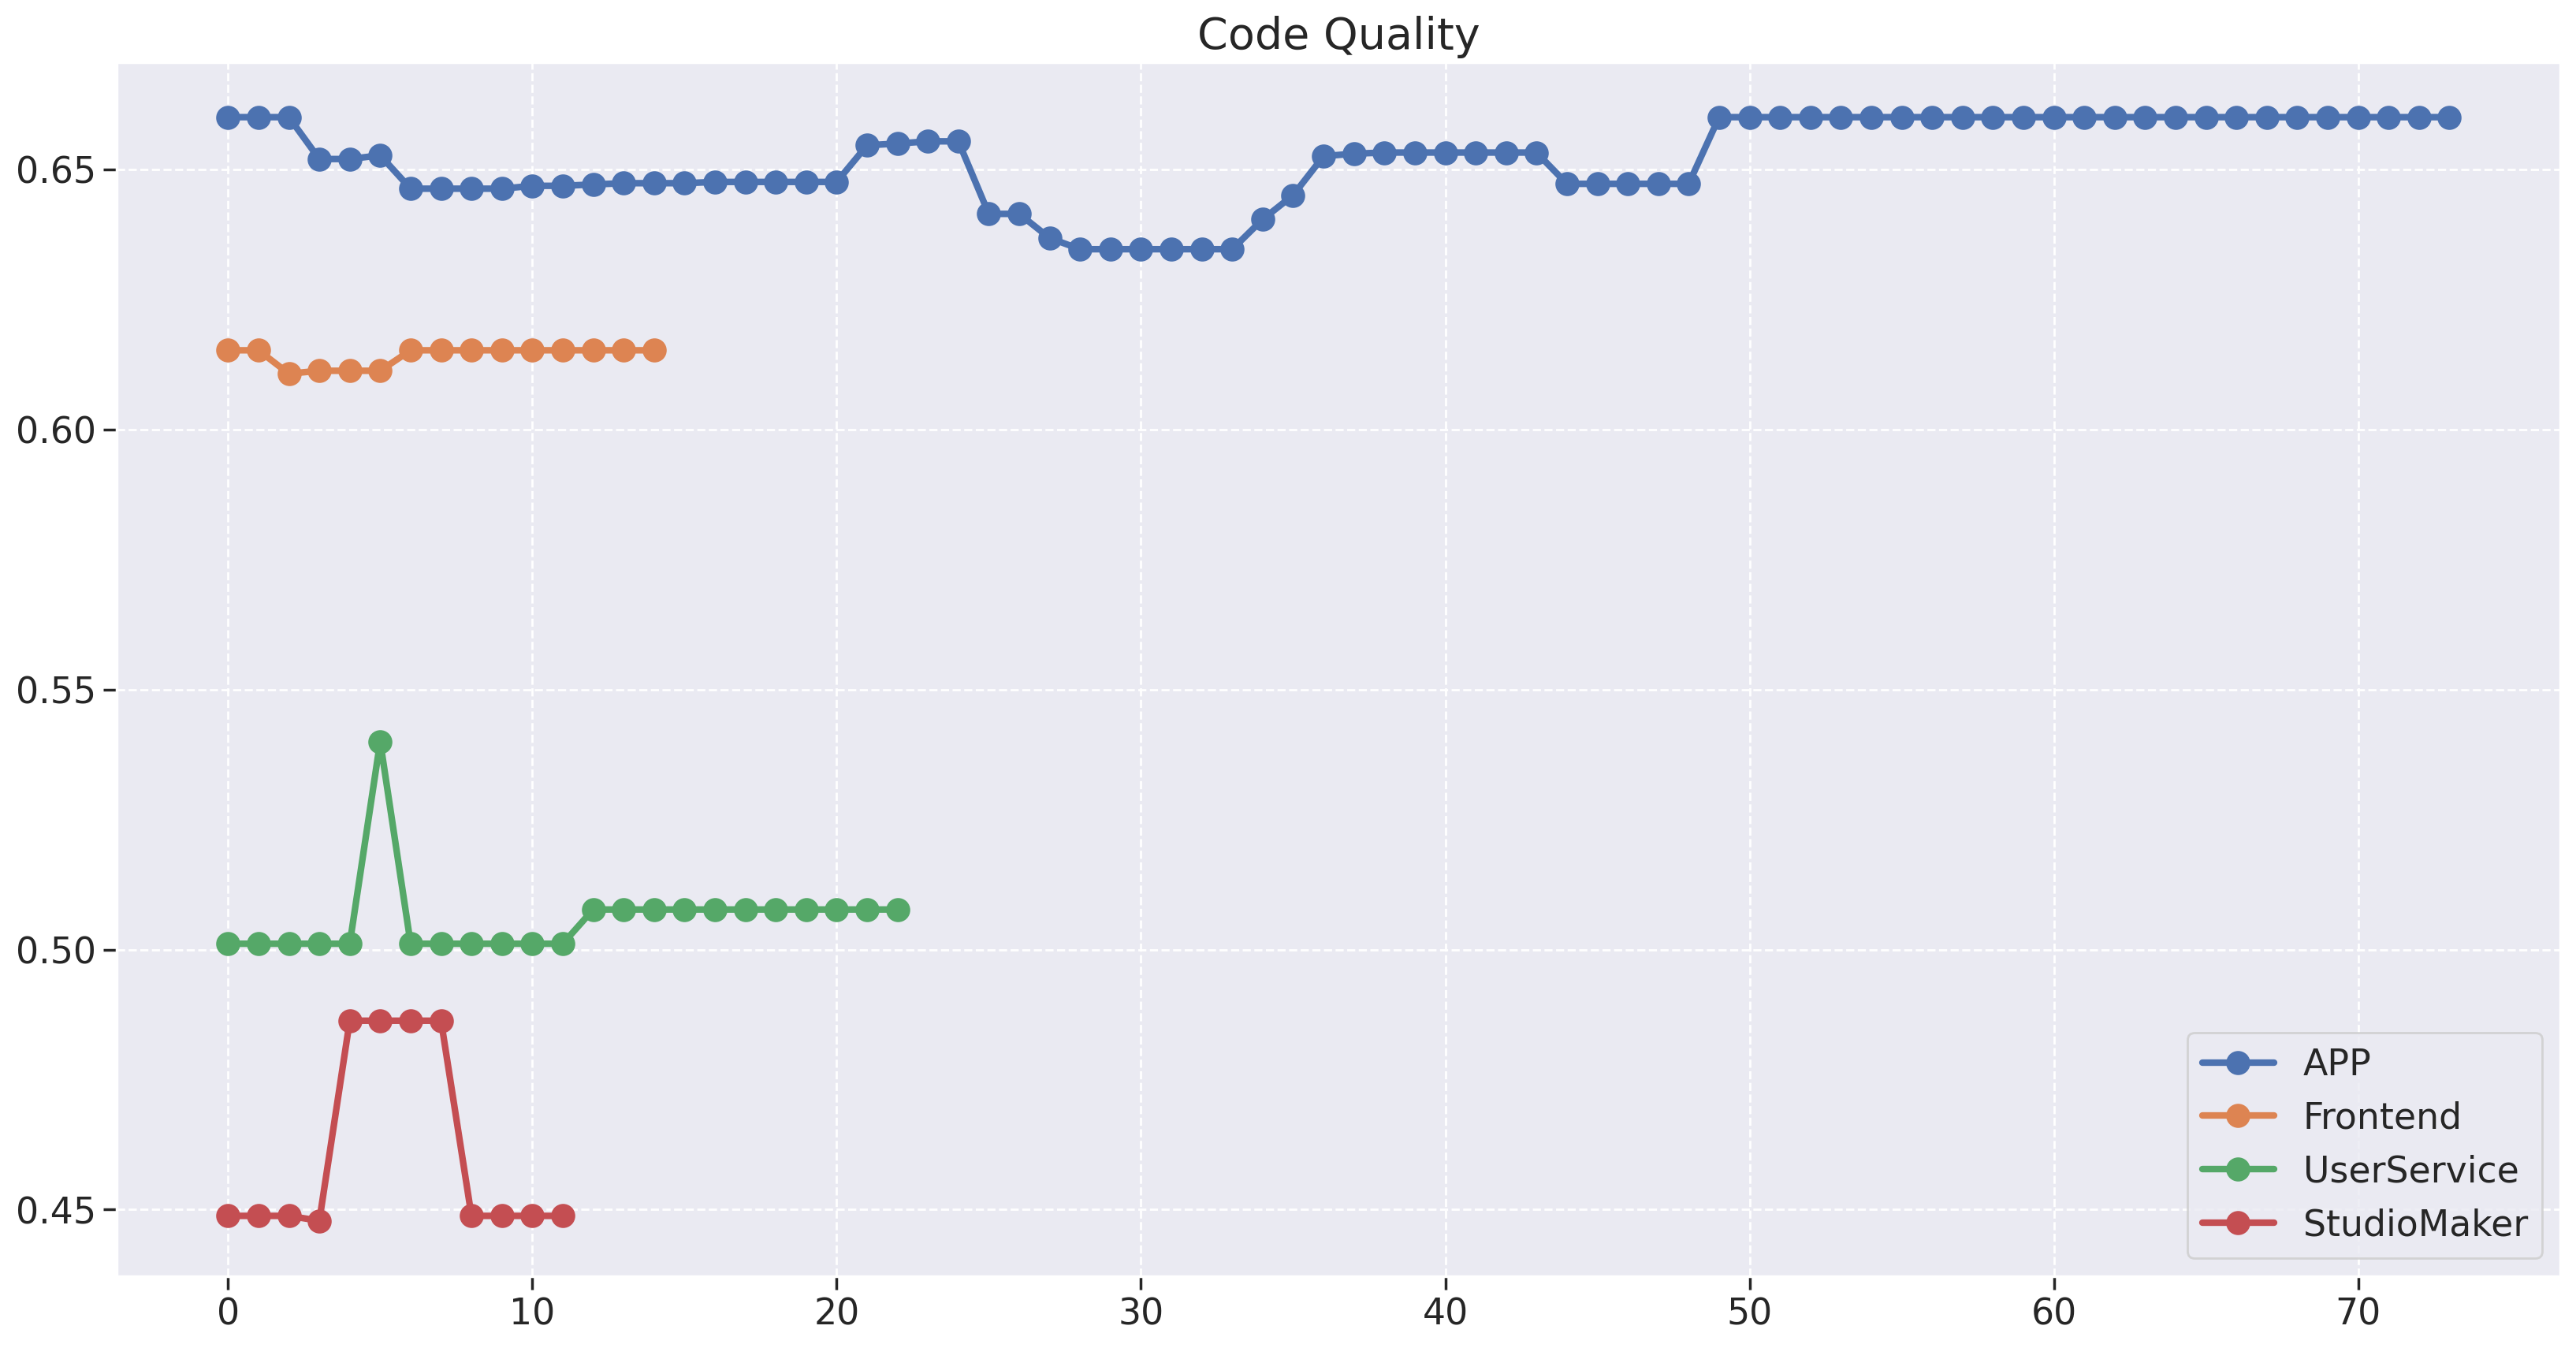

In [26]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

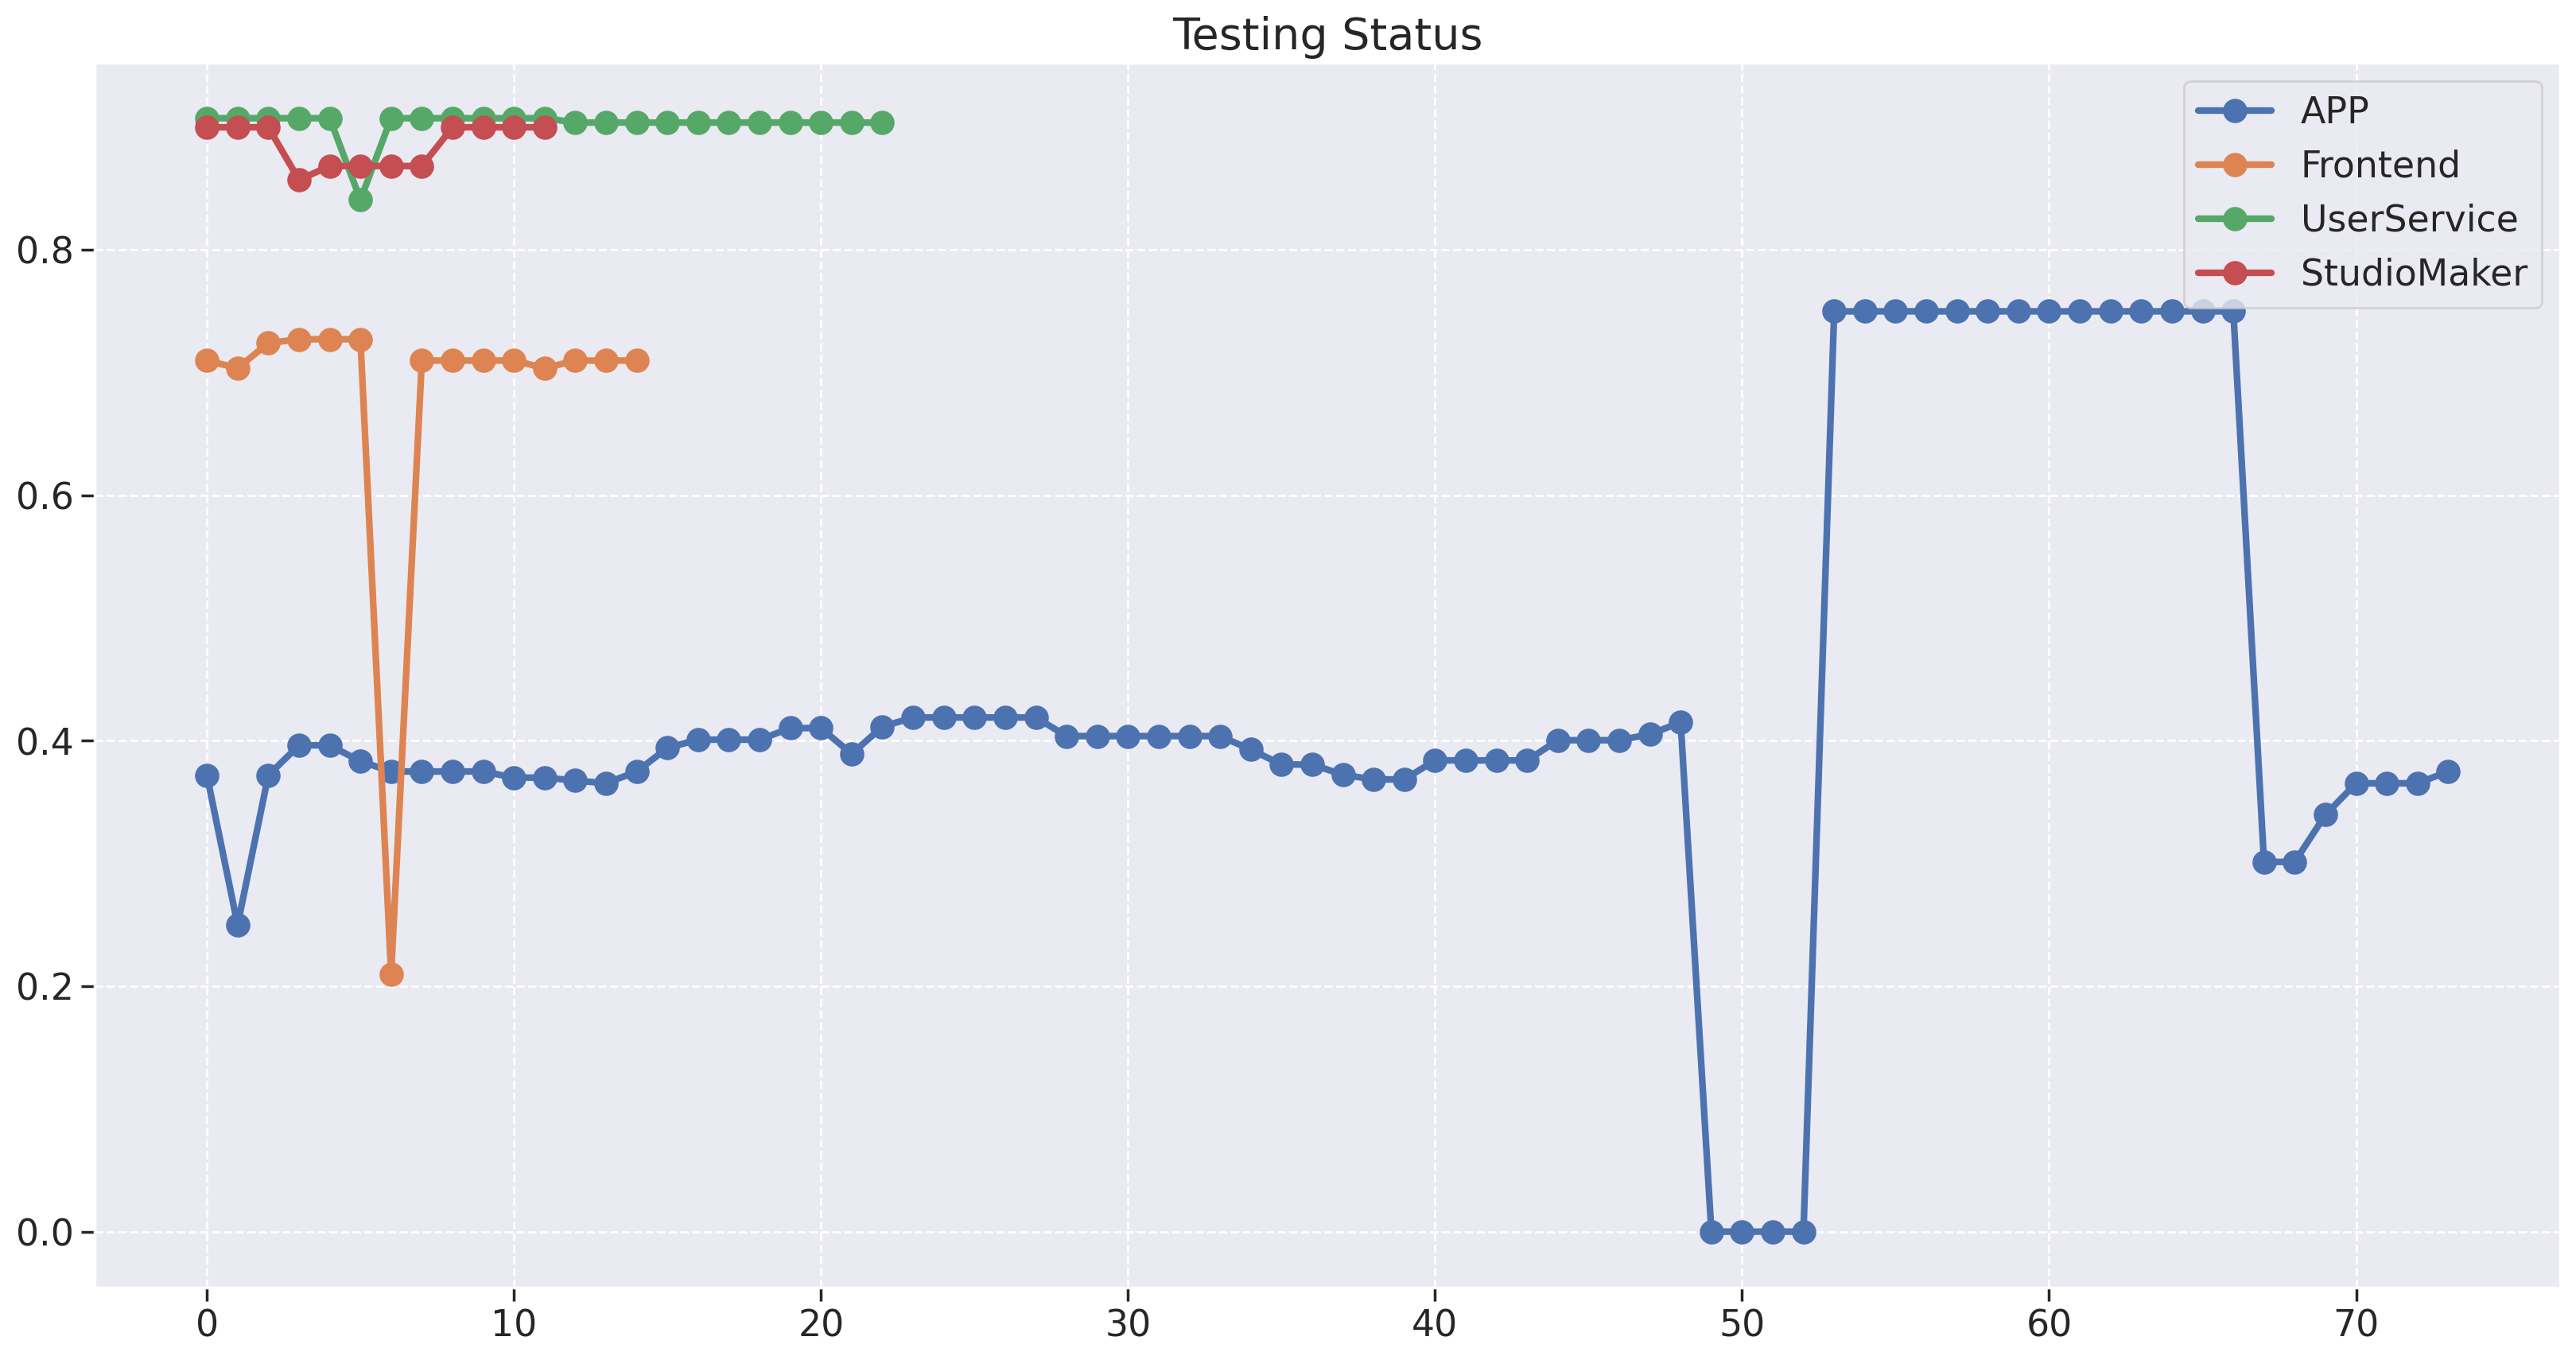

In [27]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [28]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [29]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [30]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

APP
Maintainability Stats
    mean  mode   median      std      var      min  max
0.325914  0.33 0.326598 0.004048 0.000016 0.317308 0.33
Reliability Stats
    mean  mode   median      std      var  min   max
0.216148 0.375 0.198171 0.089594 0.008027  0.0 0.375


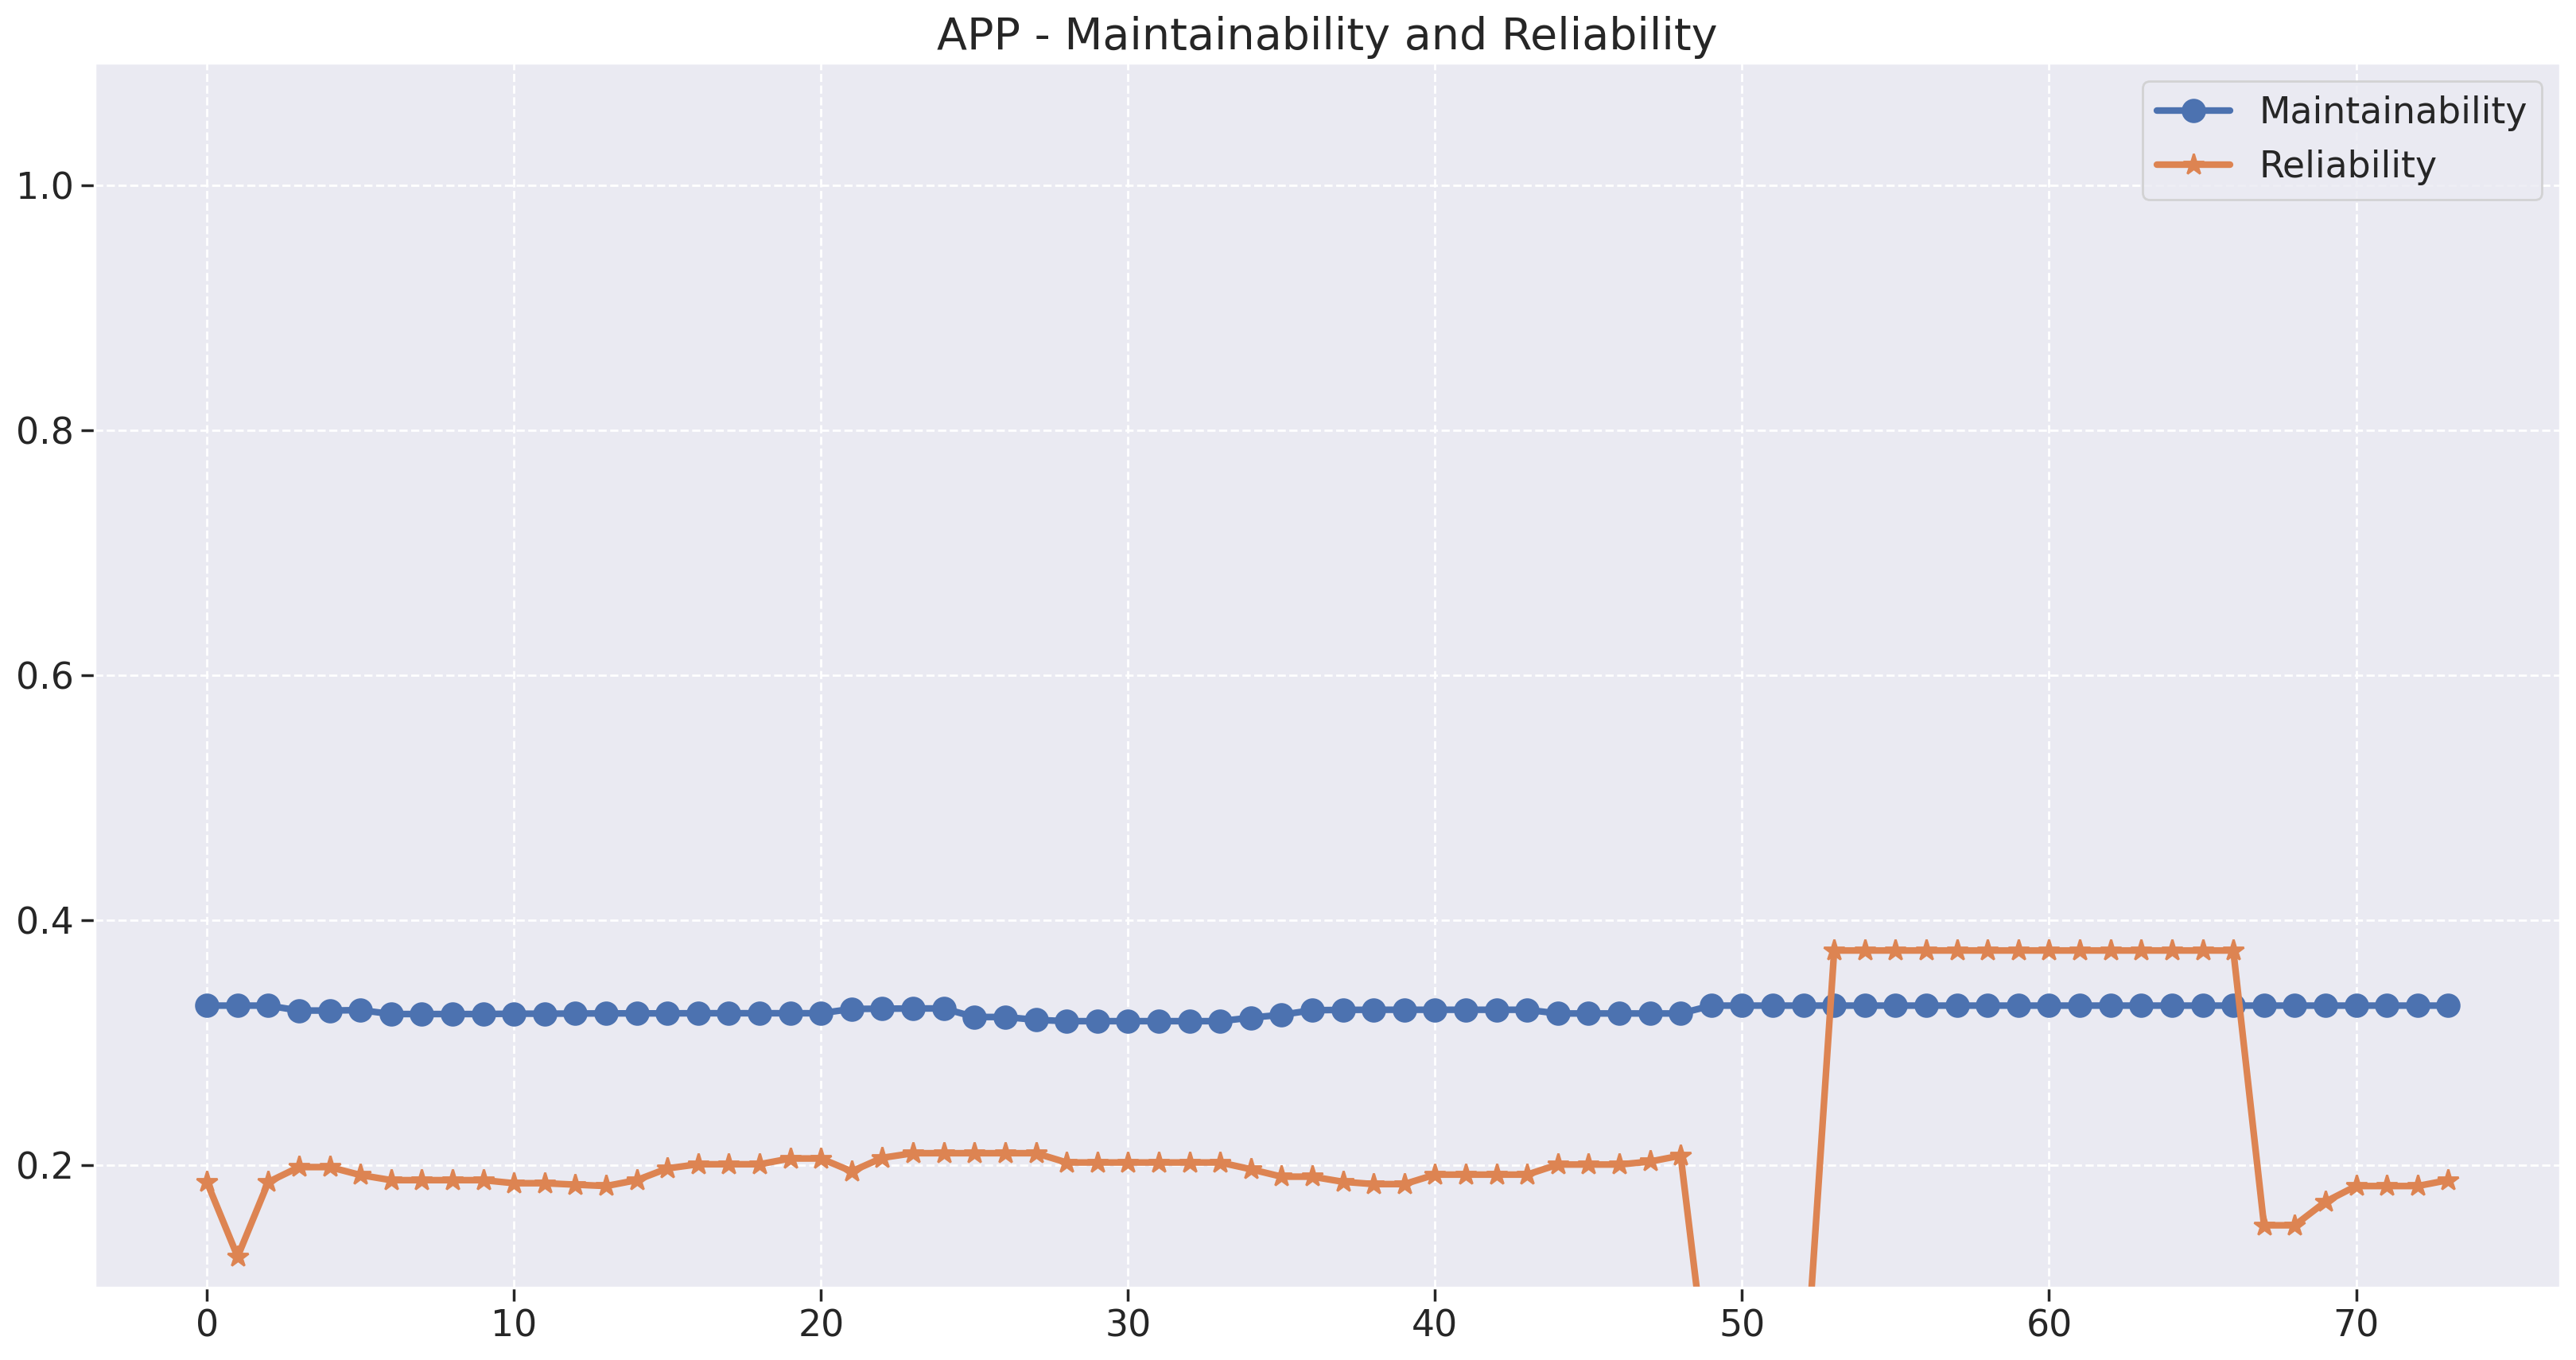

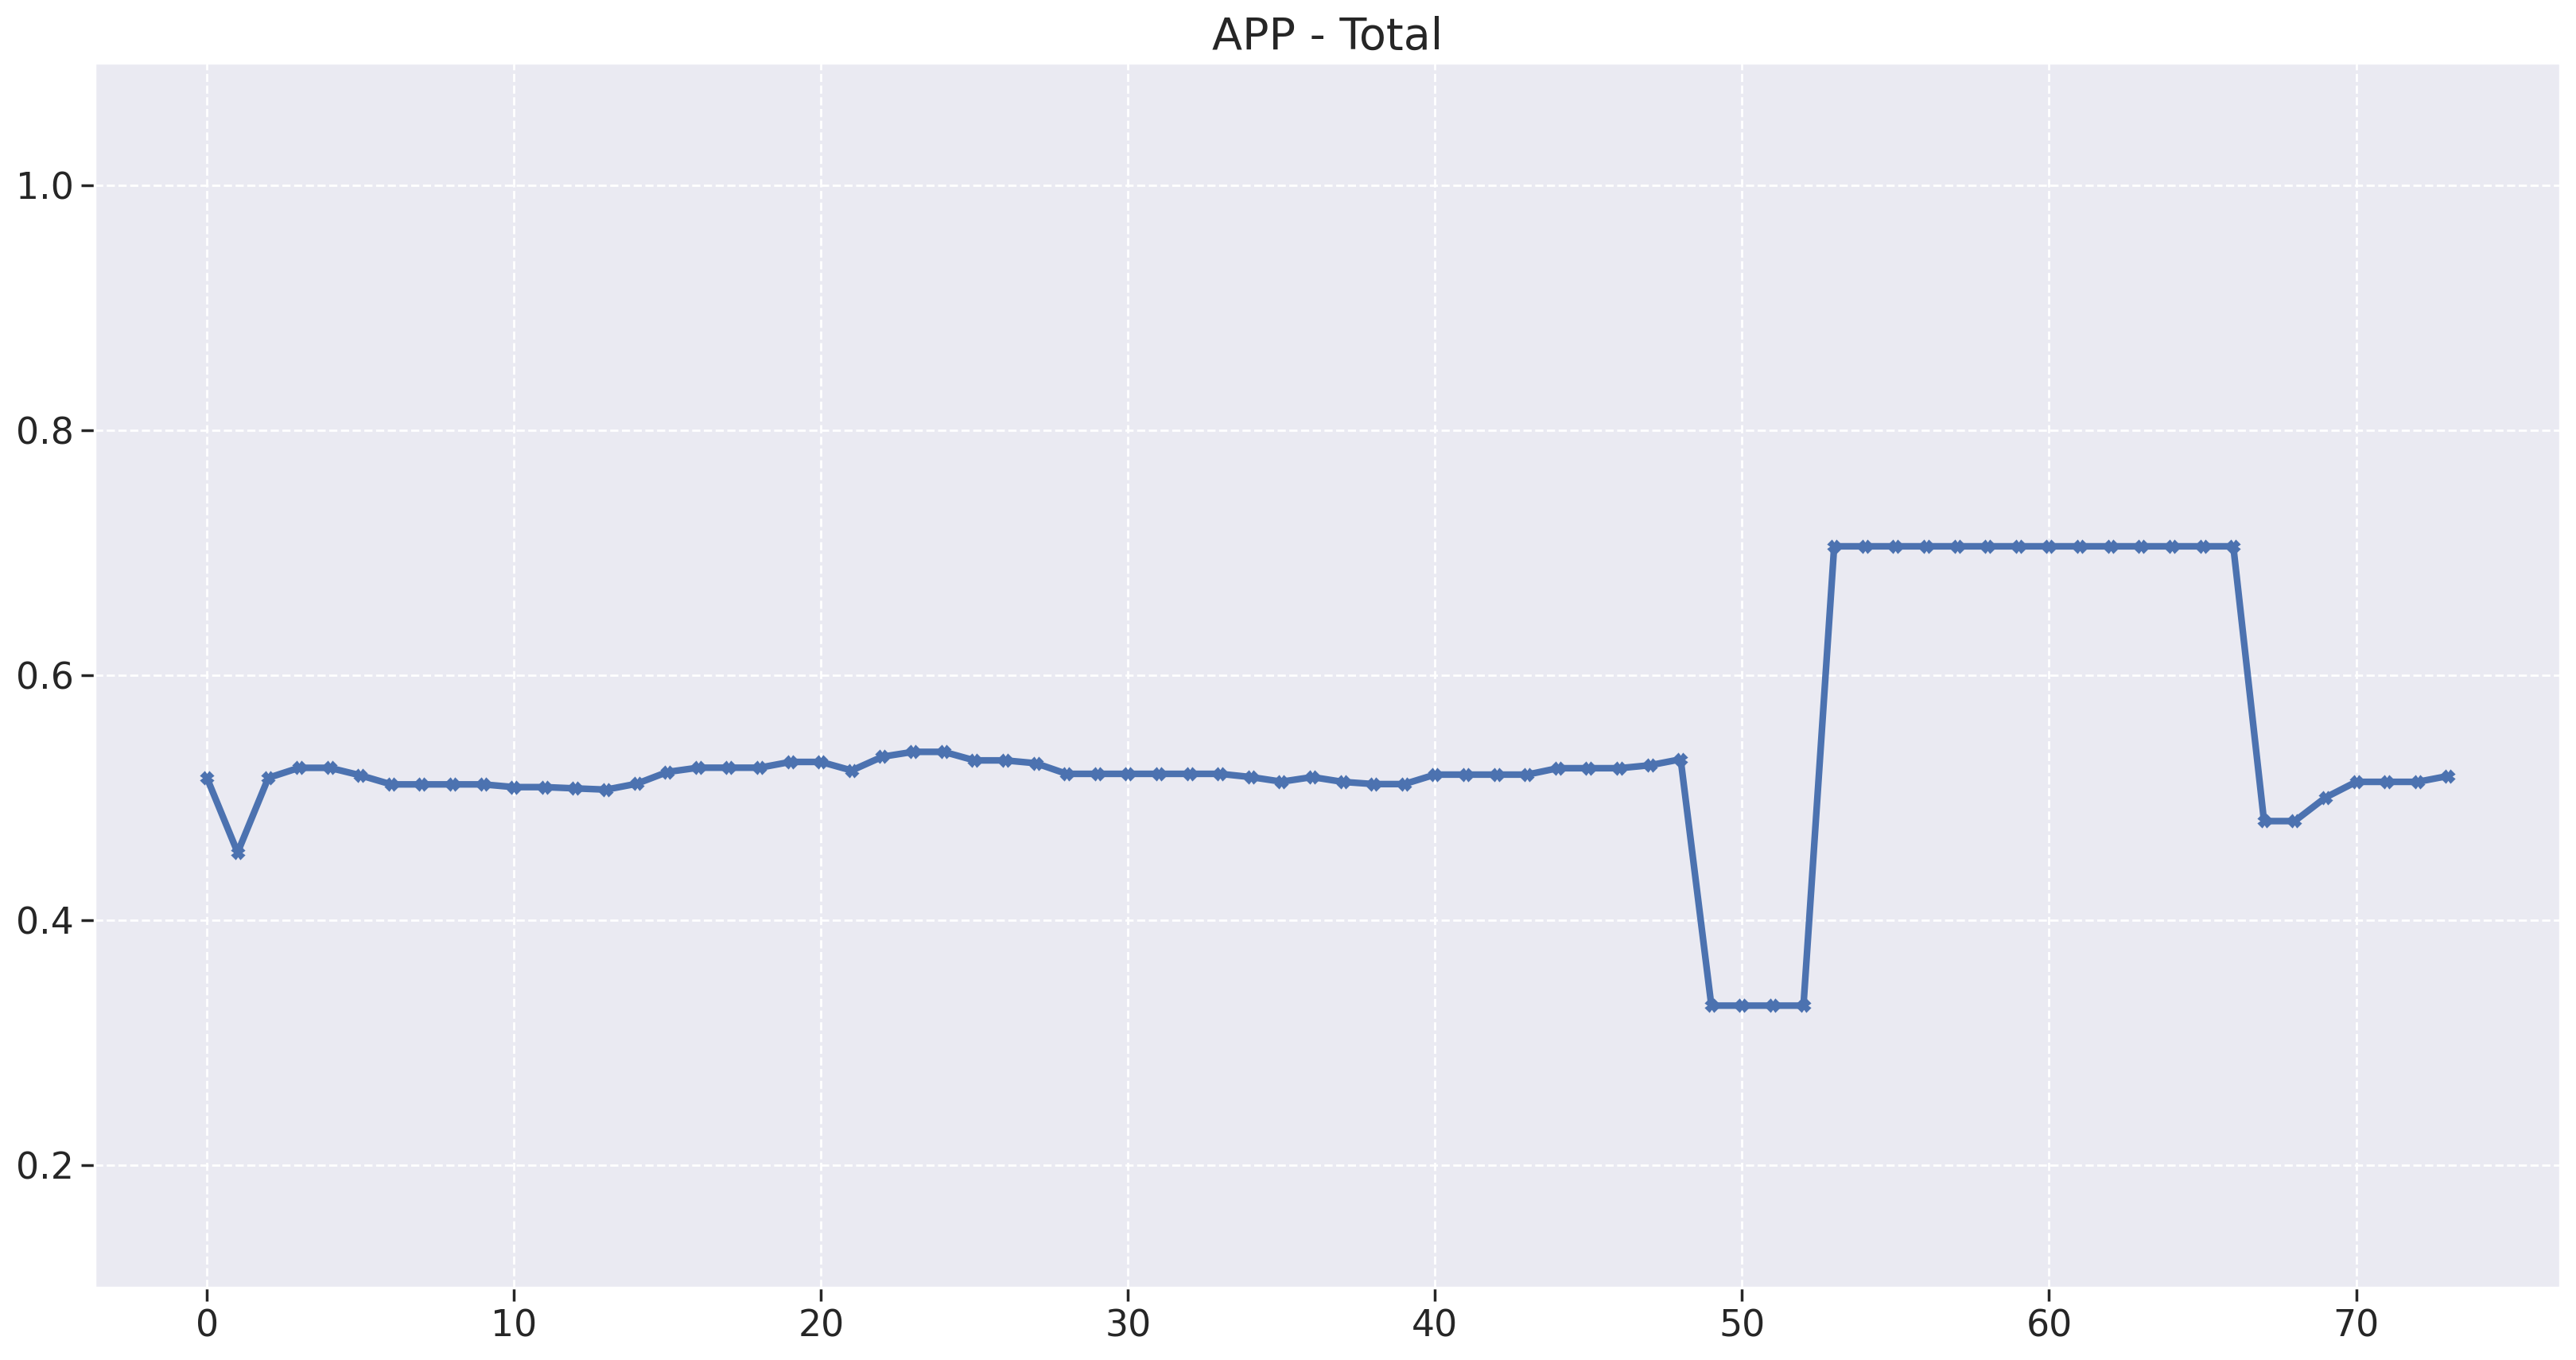

Frontend
Maintainability Stats
    mean     mode   median      std          var      min      max
0.307049 0.307593 0.307593 0.000935 8.741395e-07 0.305345 0.307593
Reliability Stats
    mean     mode   median      std      var      min      max
0.340075 0.354938 0.354938 0.065183 0.004249 0.104938 0.363636


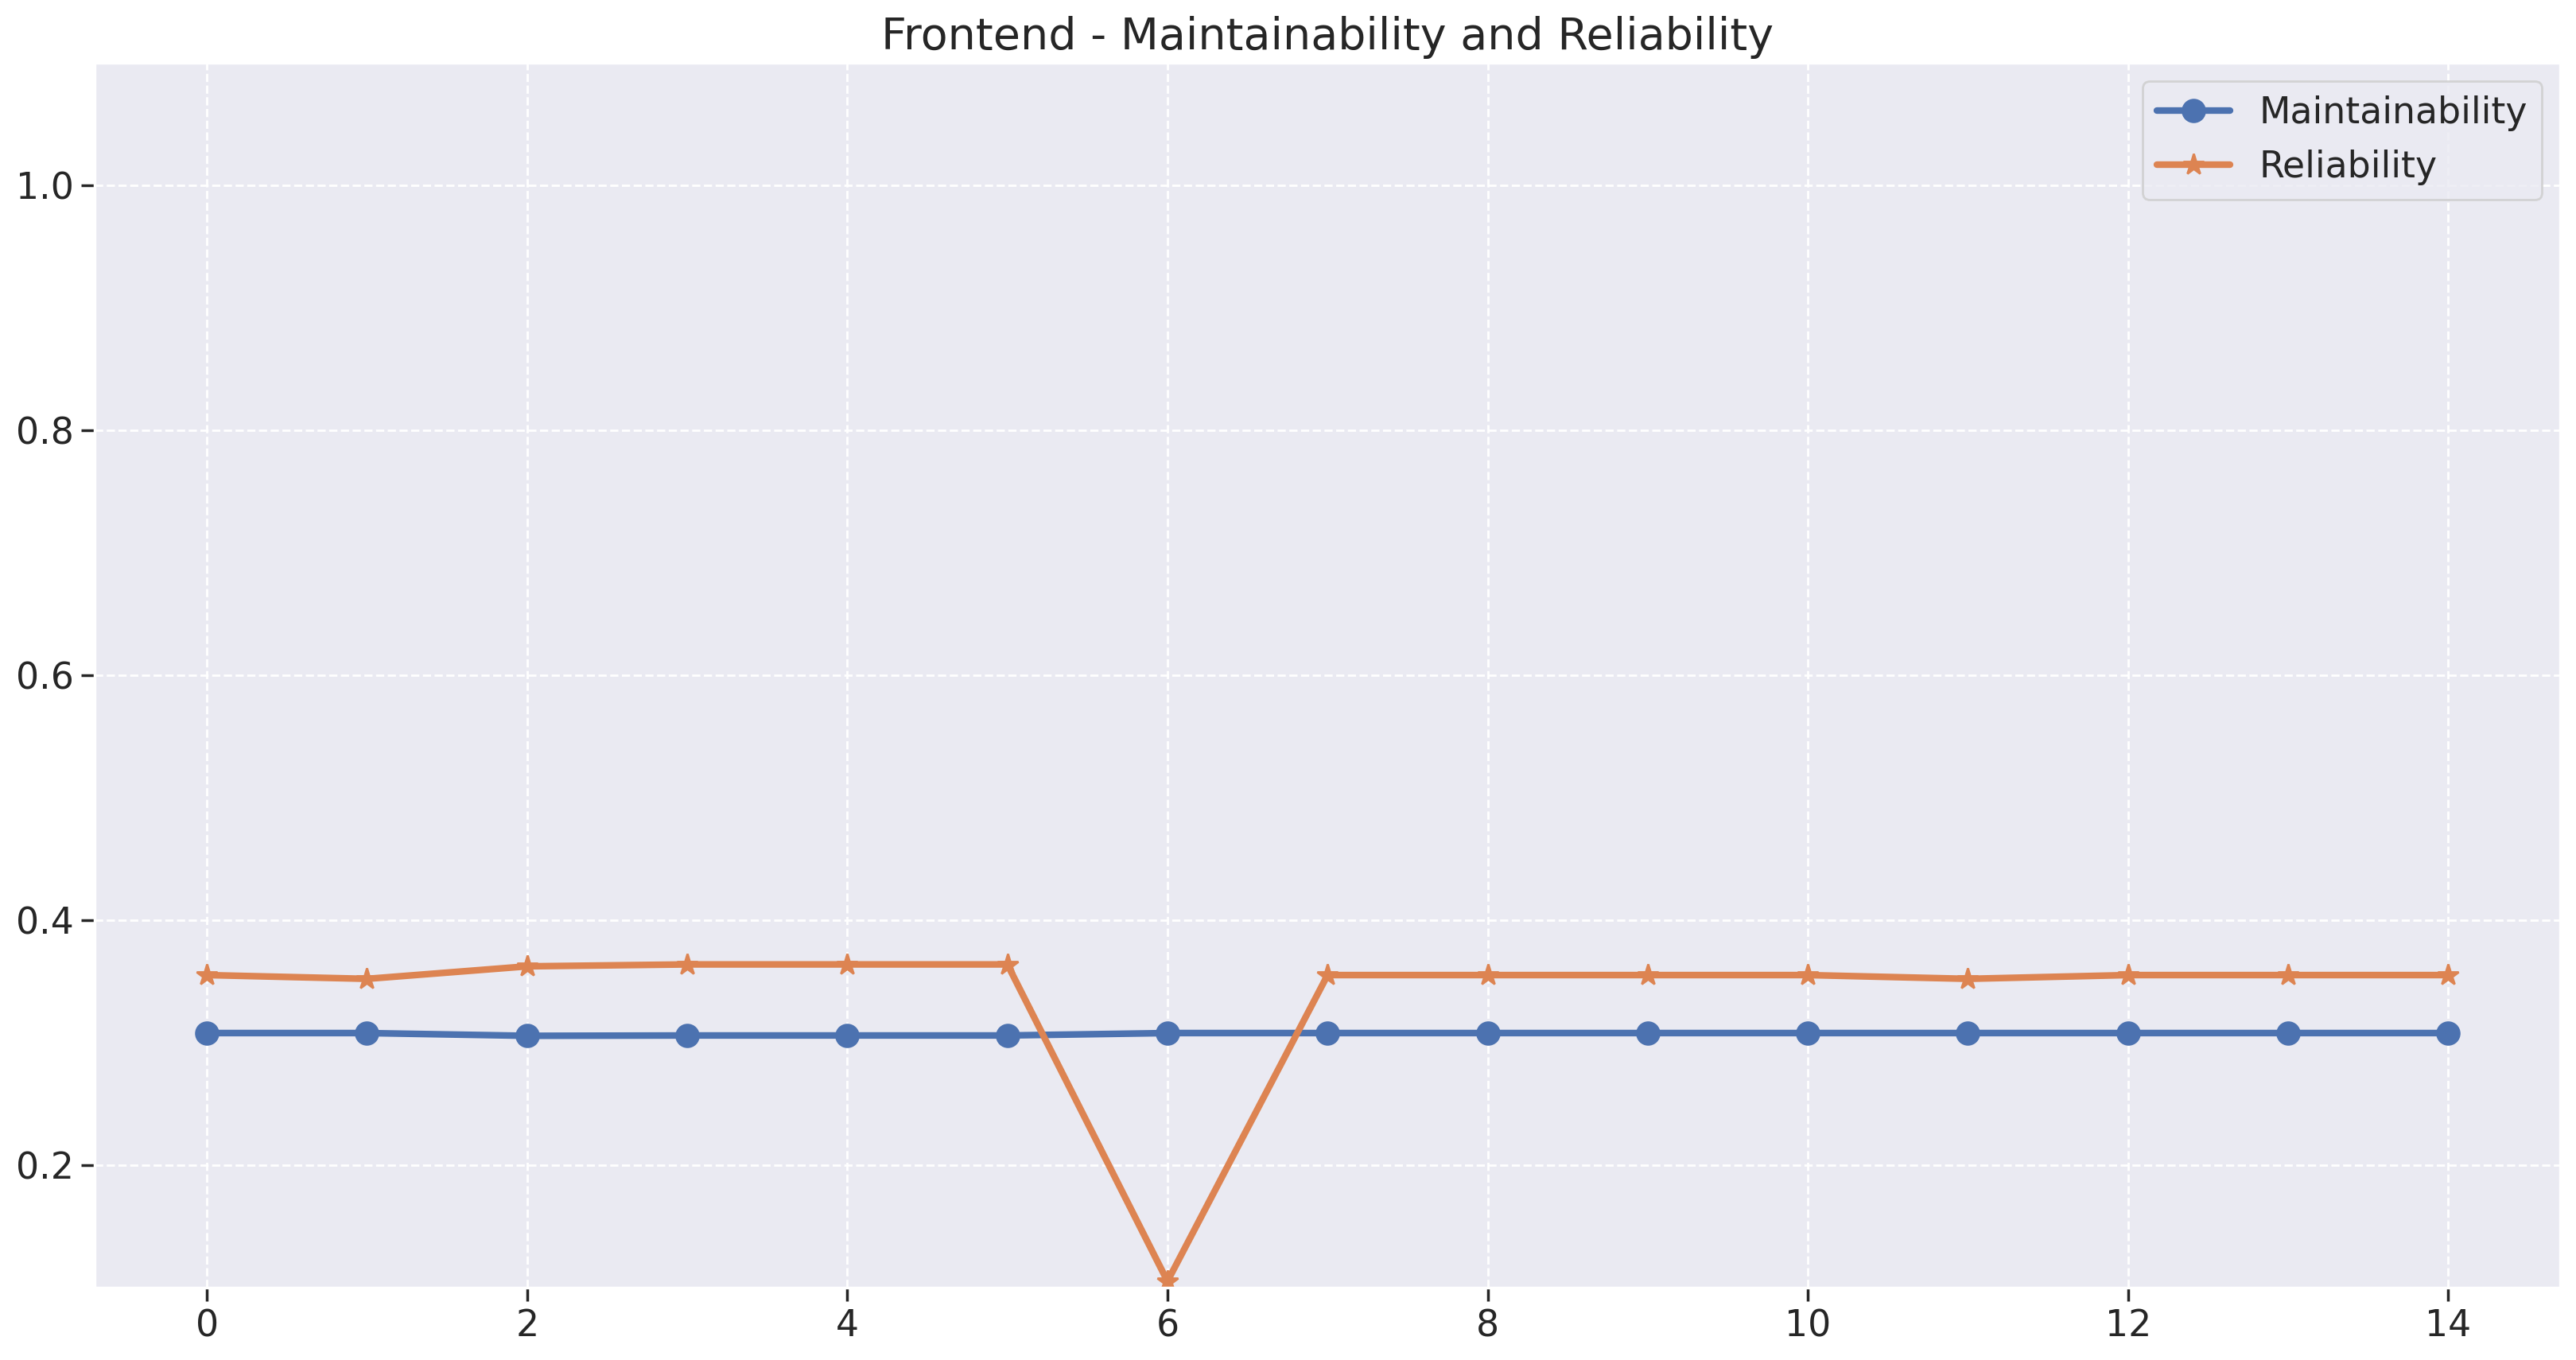

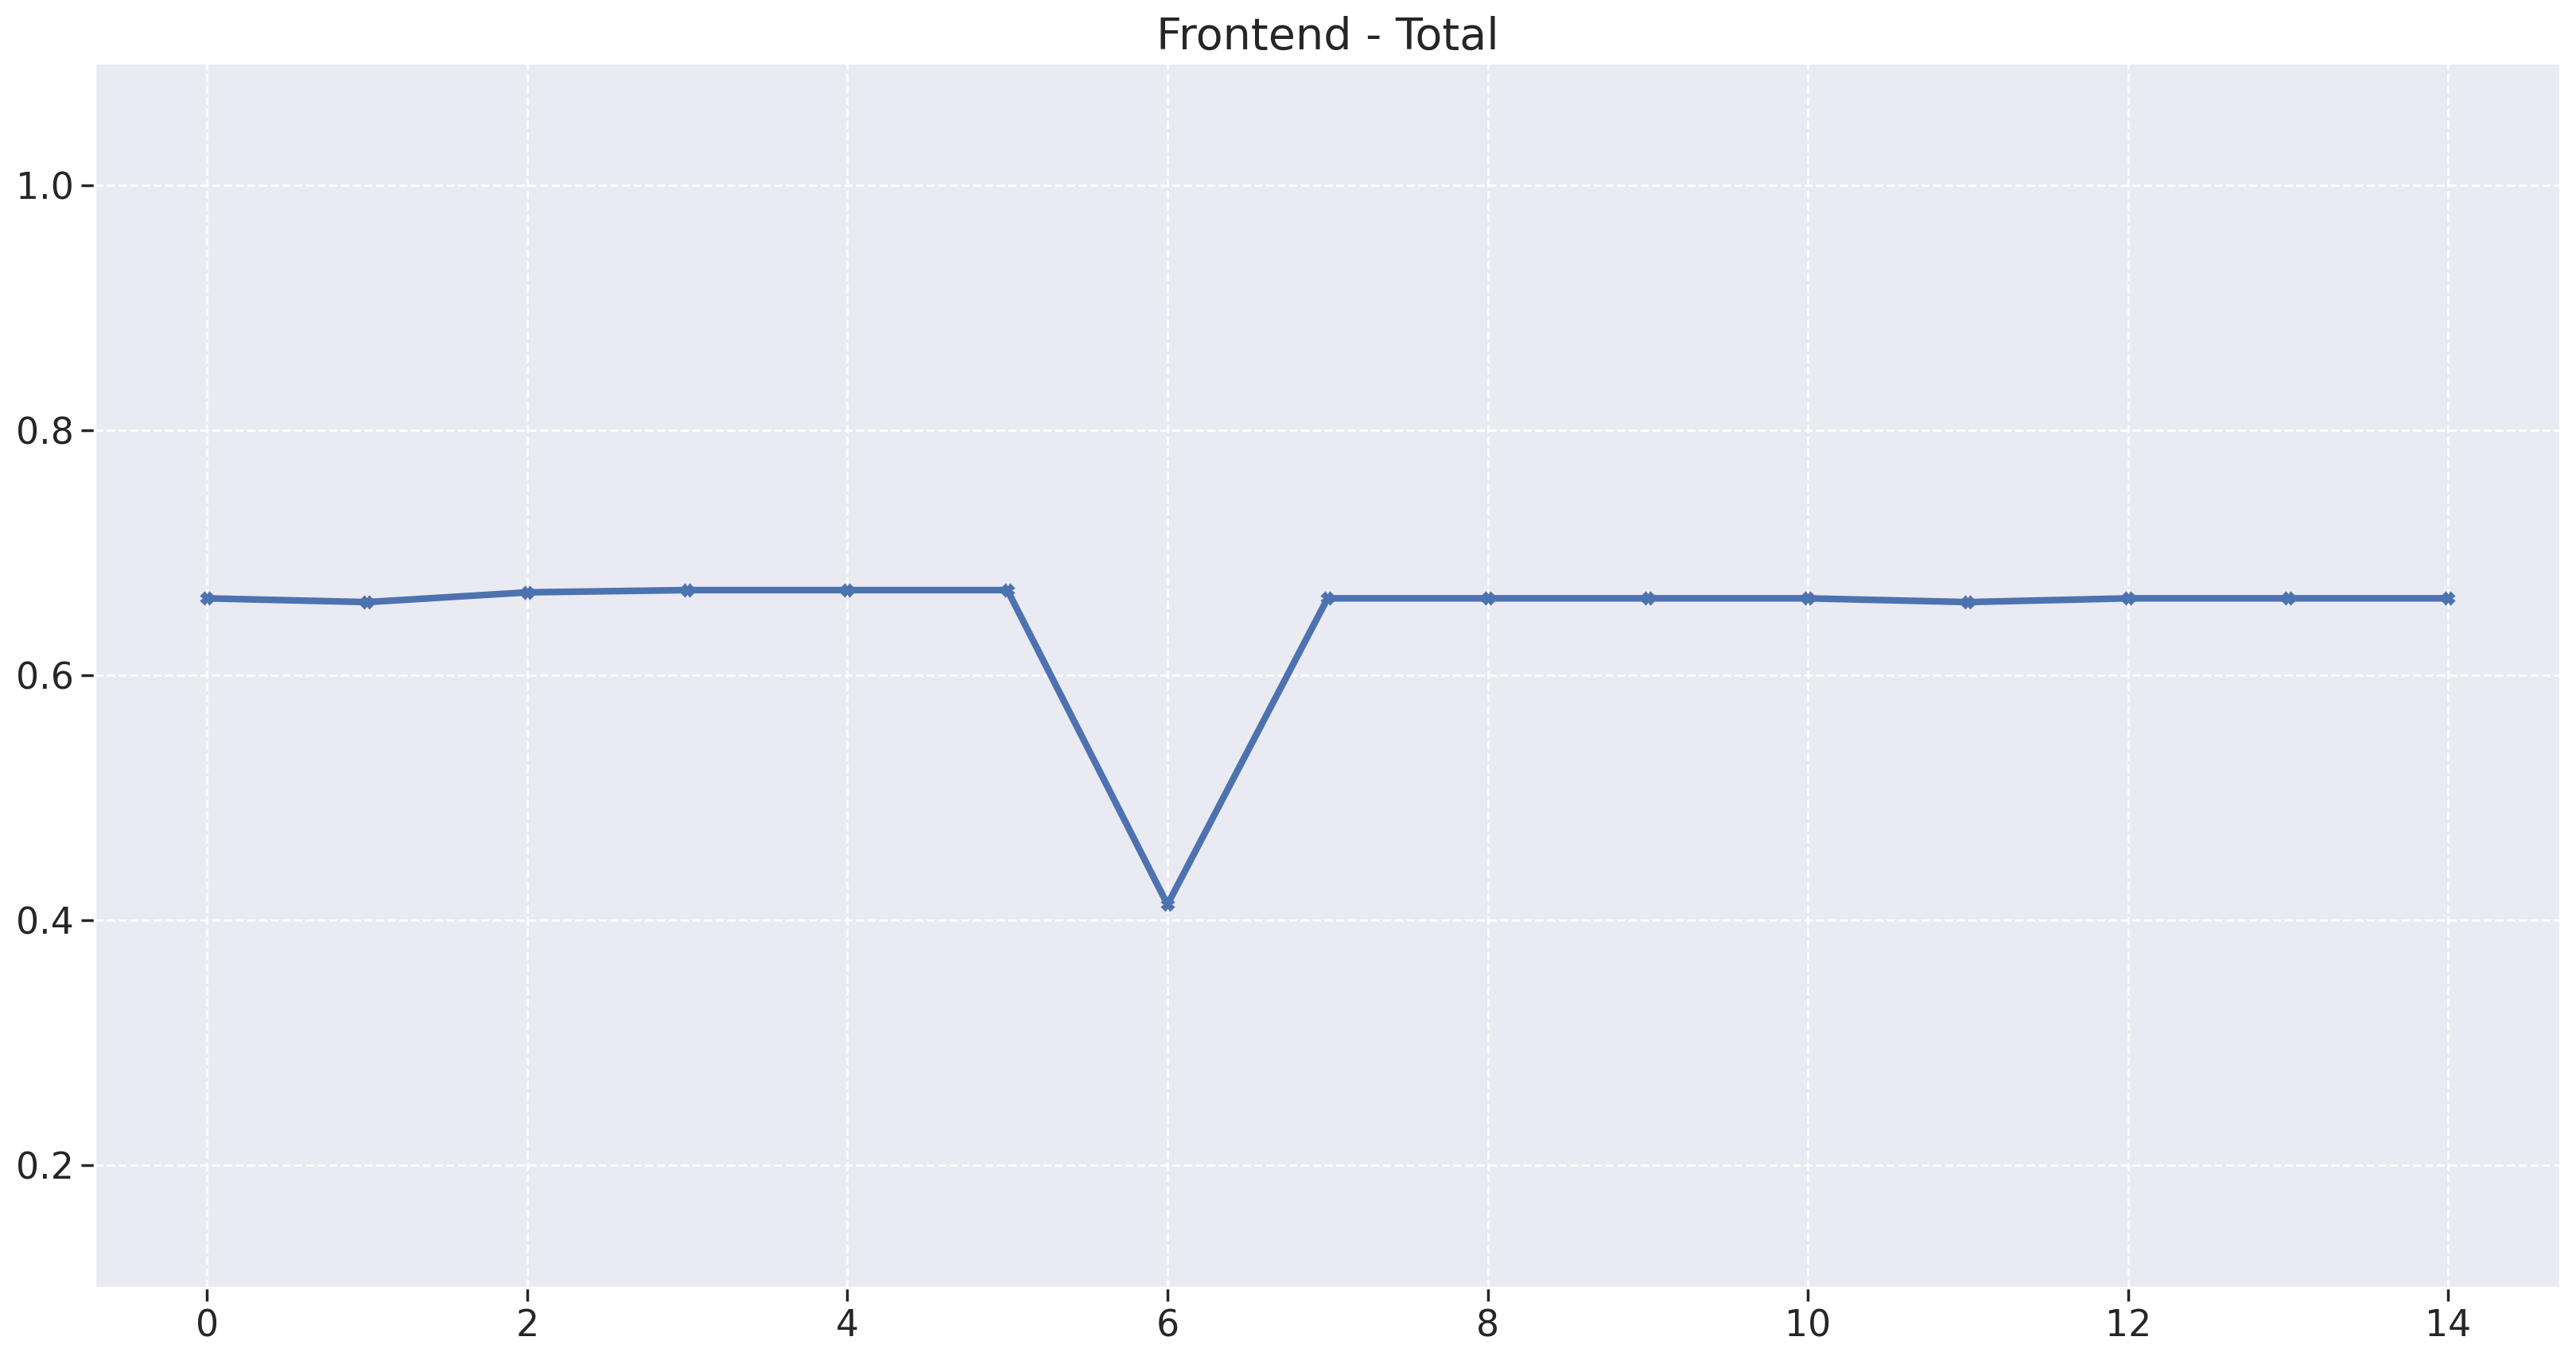

UserService
Maintainability Stats
    mean     mode   median     std      var      min  max
0.252975 0.250556 0.253846 0.00406 0.000016 0.250556 0.27
0.252975 0.253846 0.253846 0.00406 0.000016 0.250556 0.27
Reliability Stats
    mean     mode   median      std      var      min      max
0.451406 0.451923 0.451923 0.006806 0.000046 0.420455 0.453704
0.451406 0.453704 0.451923 0.006806 0.000046 0.420455 0.453704


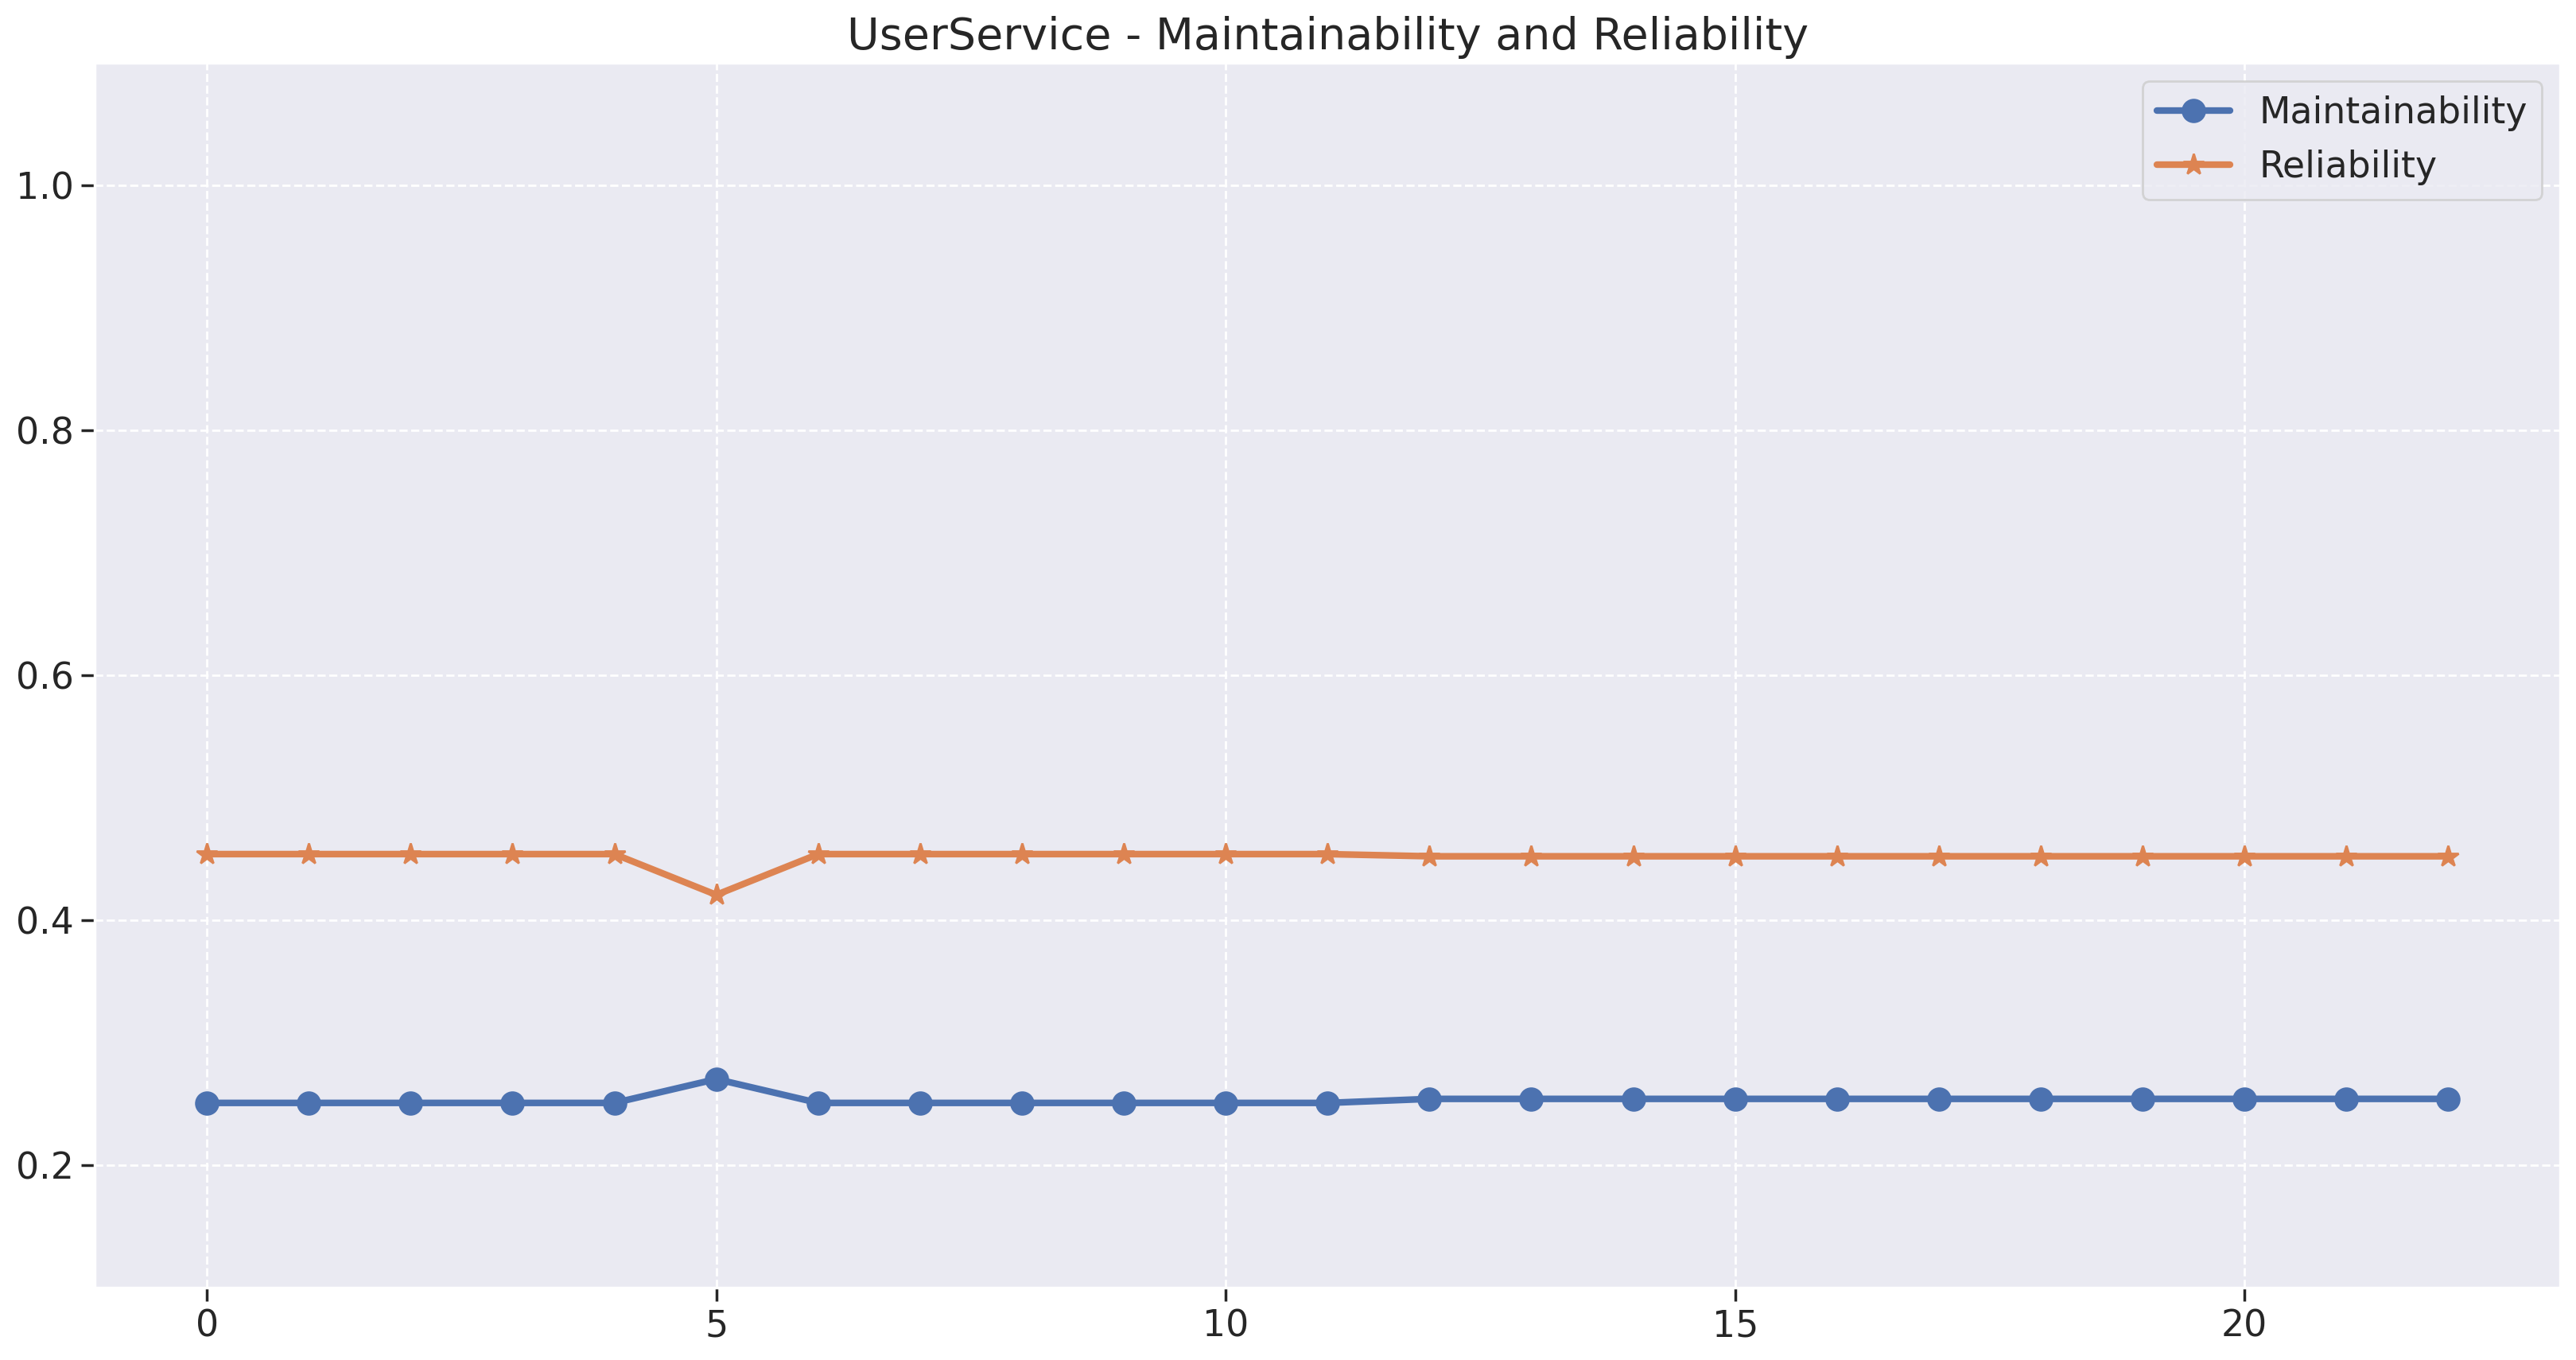

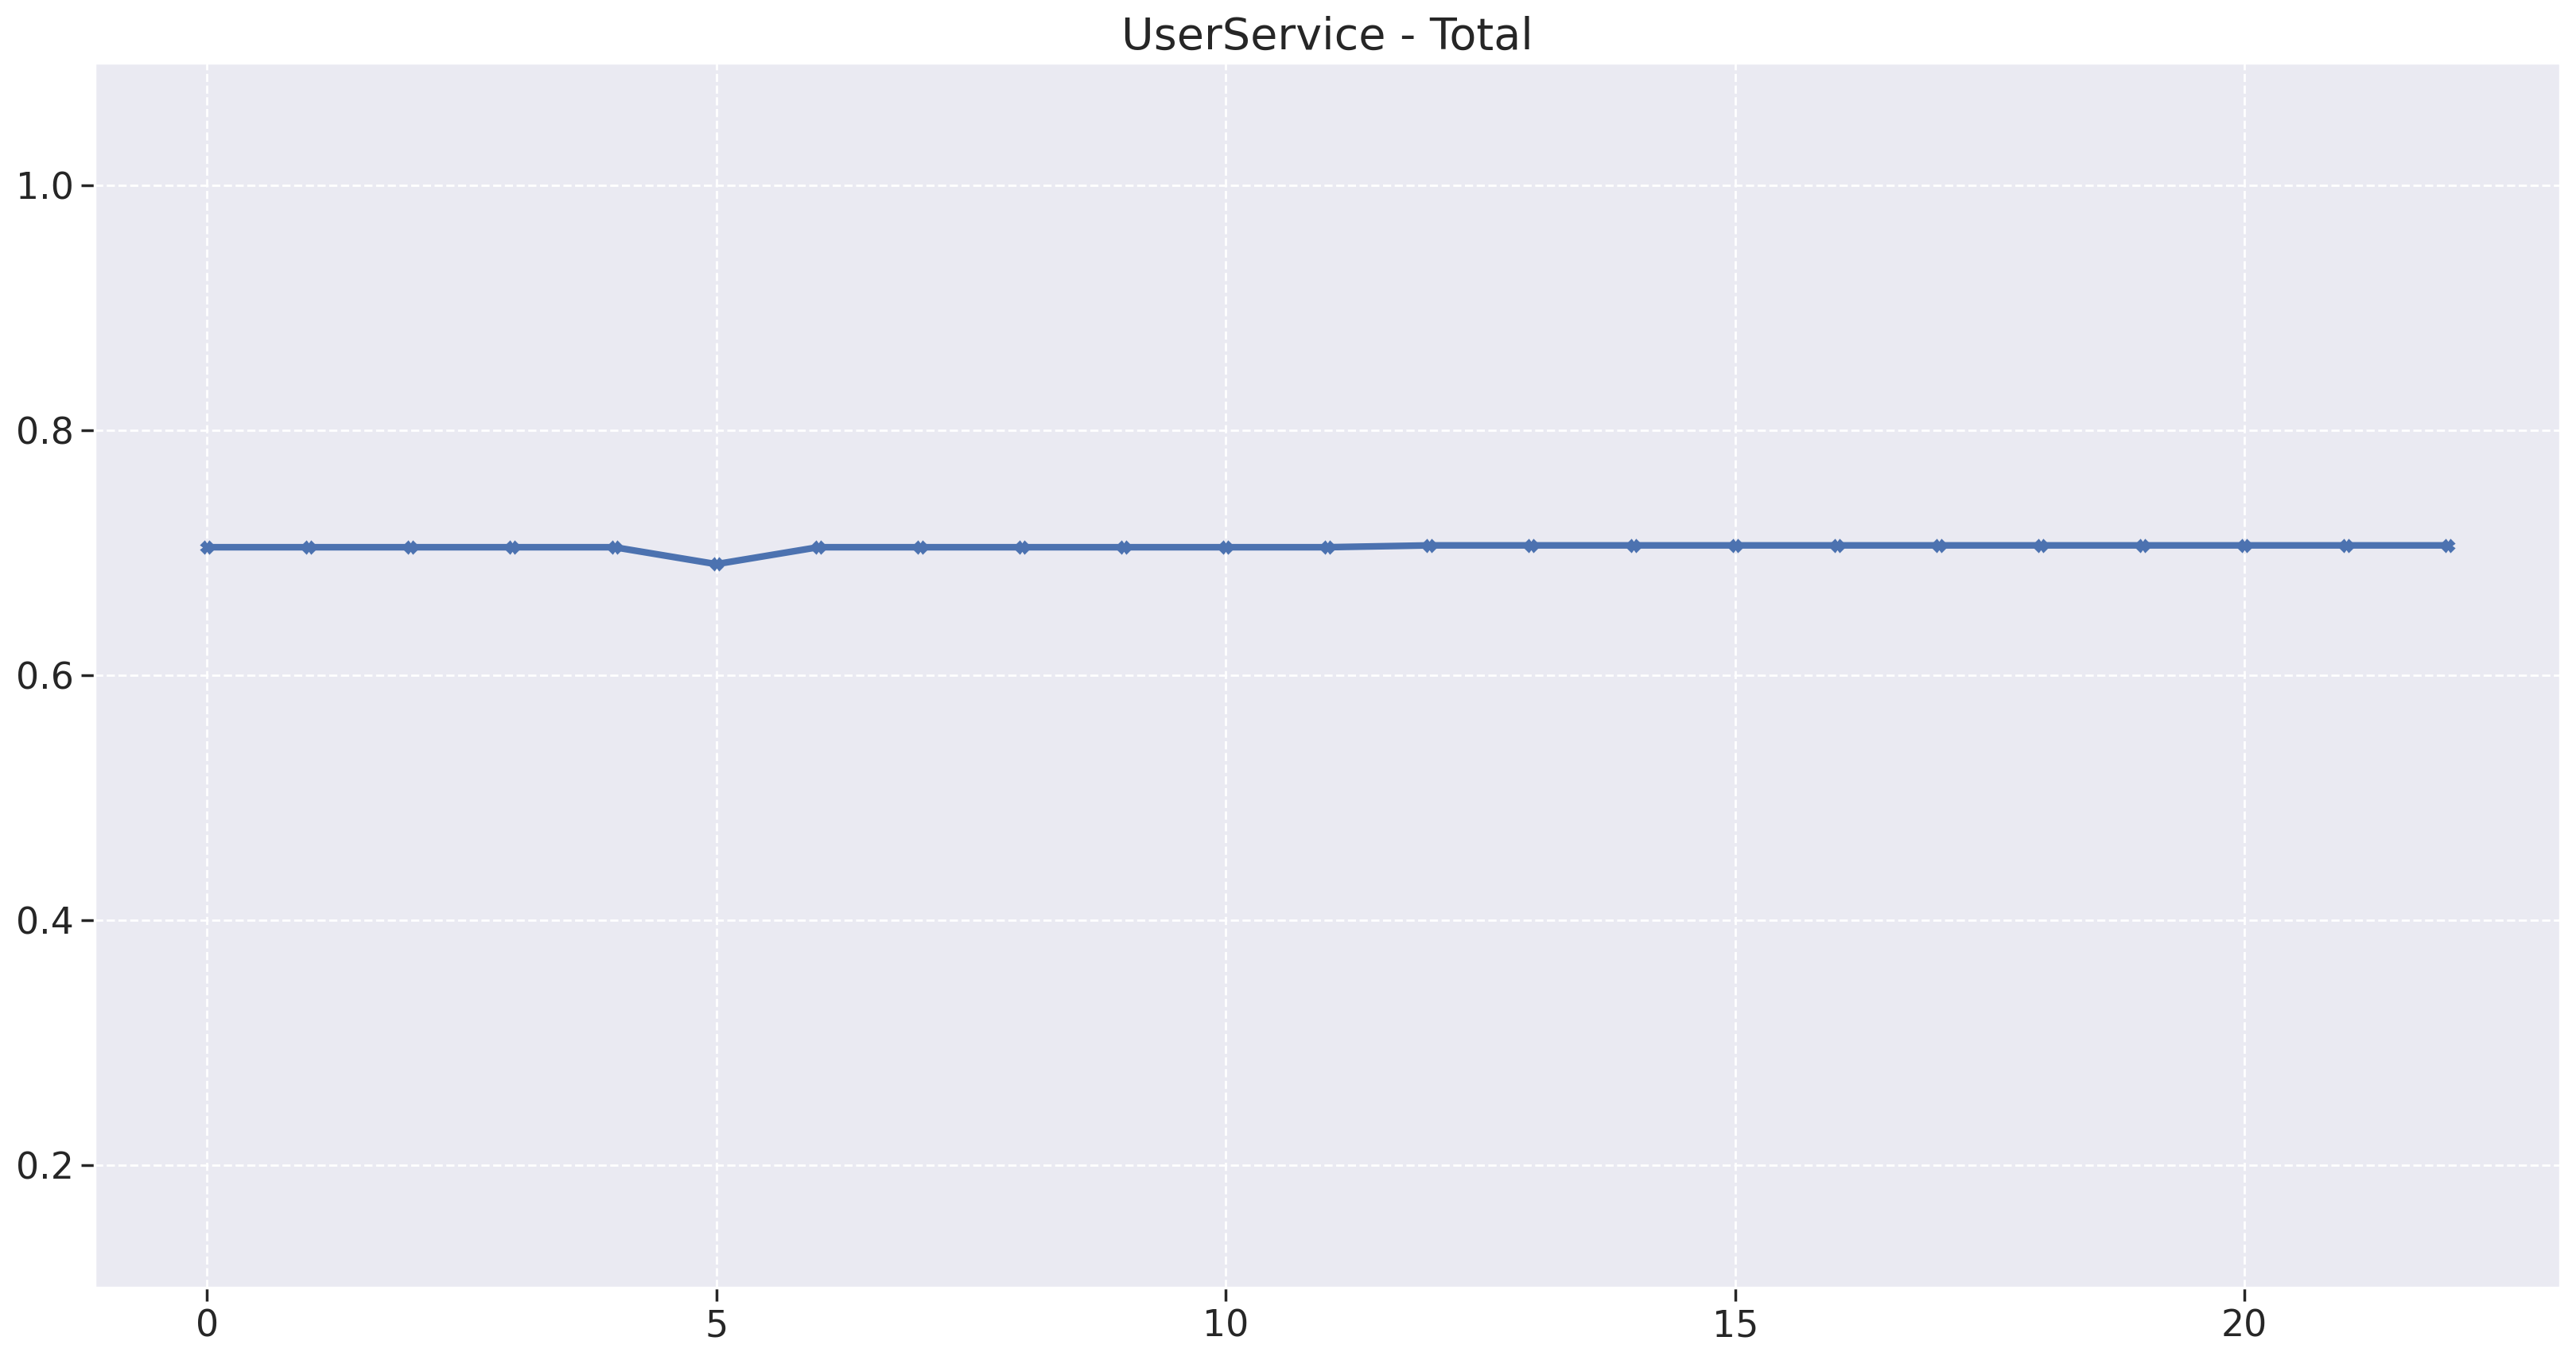

StudioMaker
Maintainability Stats
    mean   mode  median      std      var      min      max
0.230613 0.2244  0.2244 0.009266 0.000086 0.223929 0.243158
Reliability Stats
    mean  mode  median      std      var      min  max
0.442951  0.45    0.45 0.008843 0.000078 0.428571 0.45


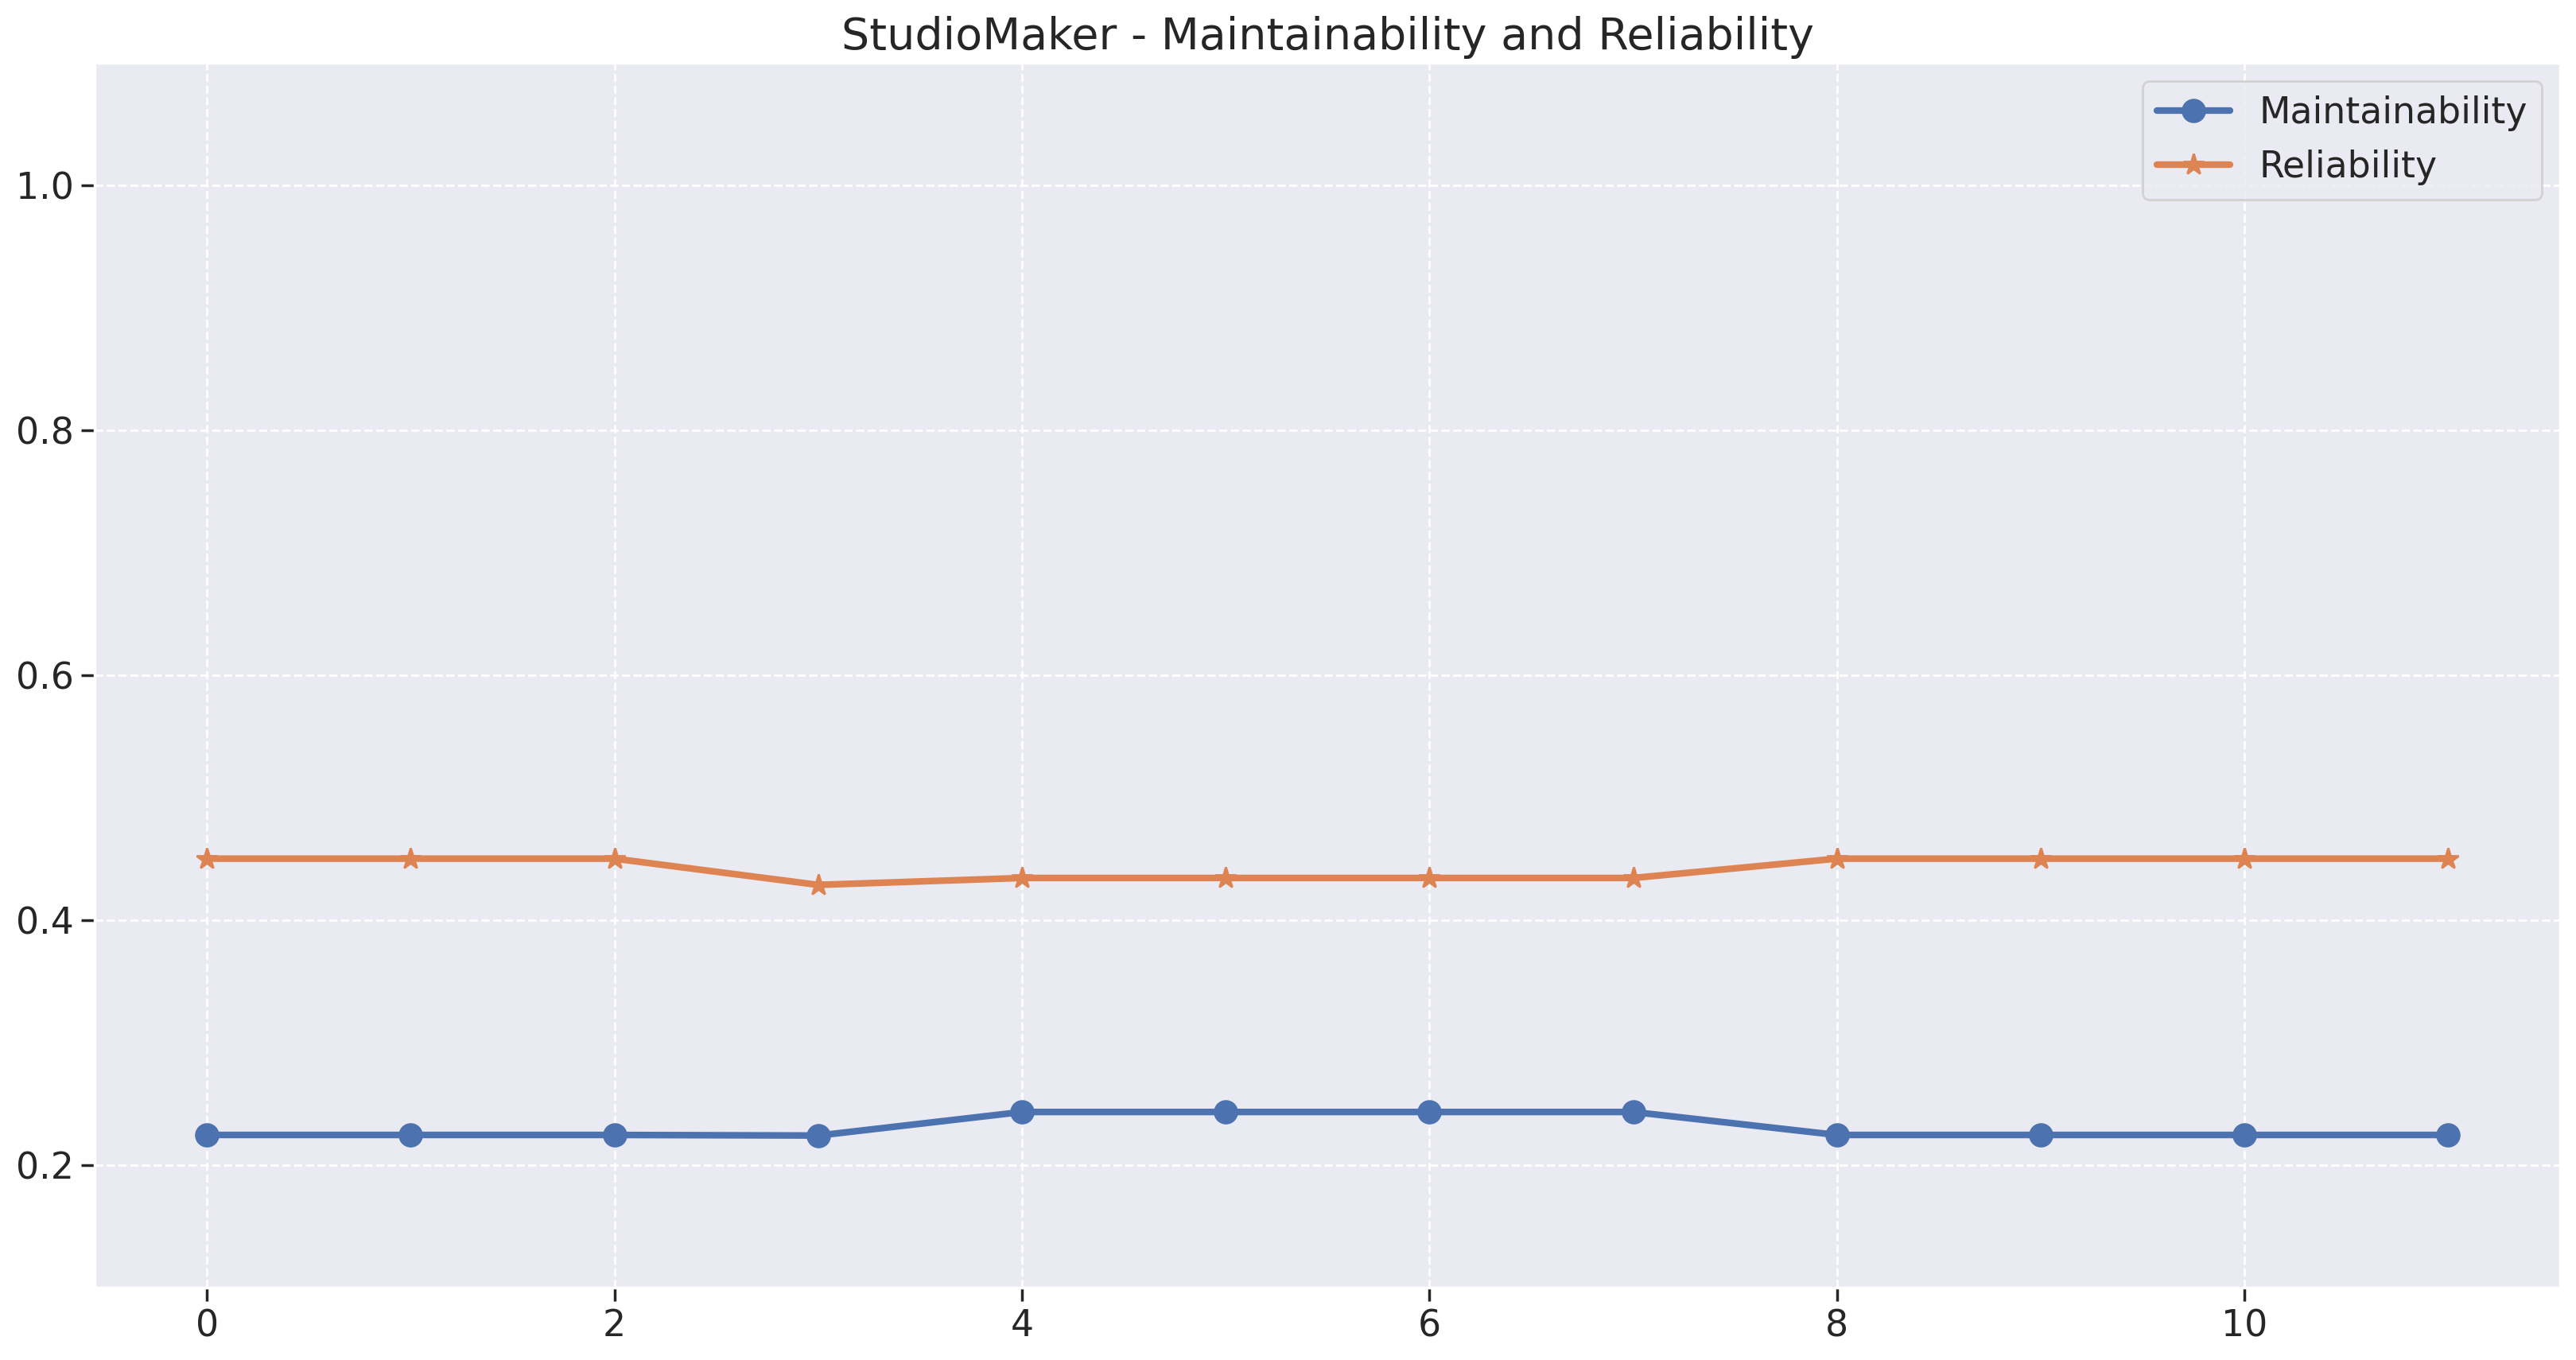

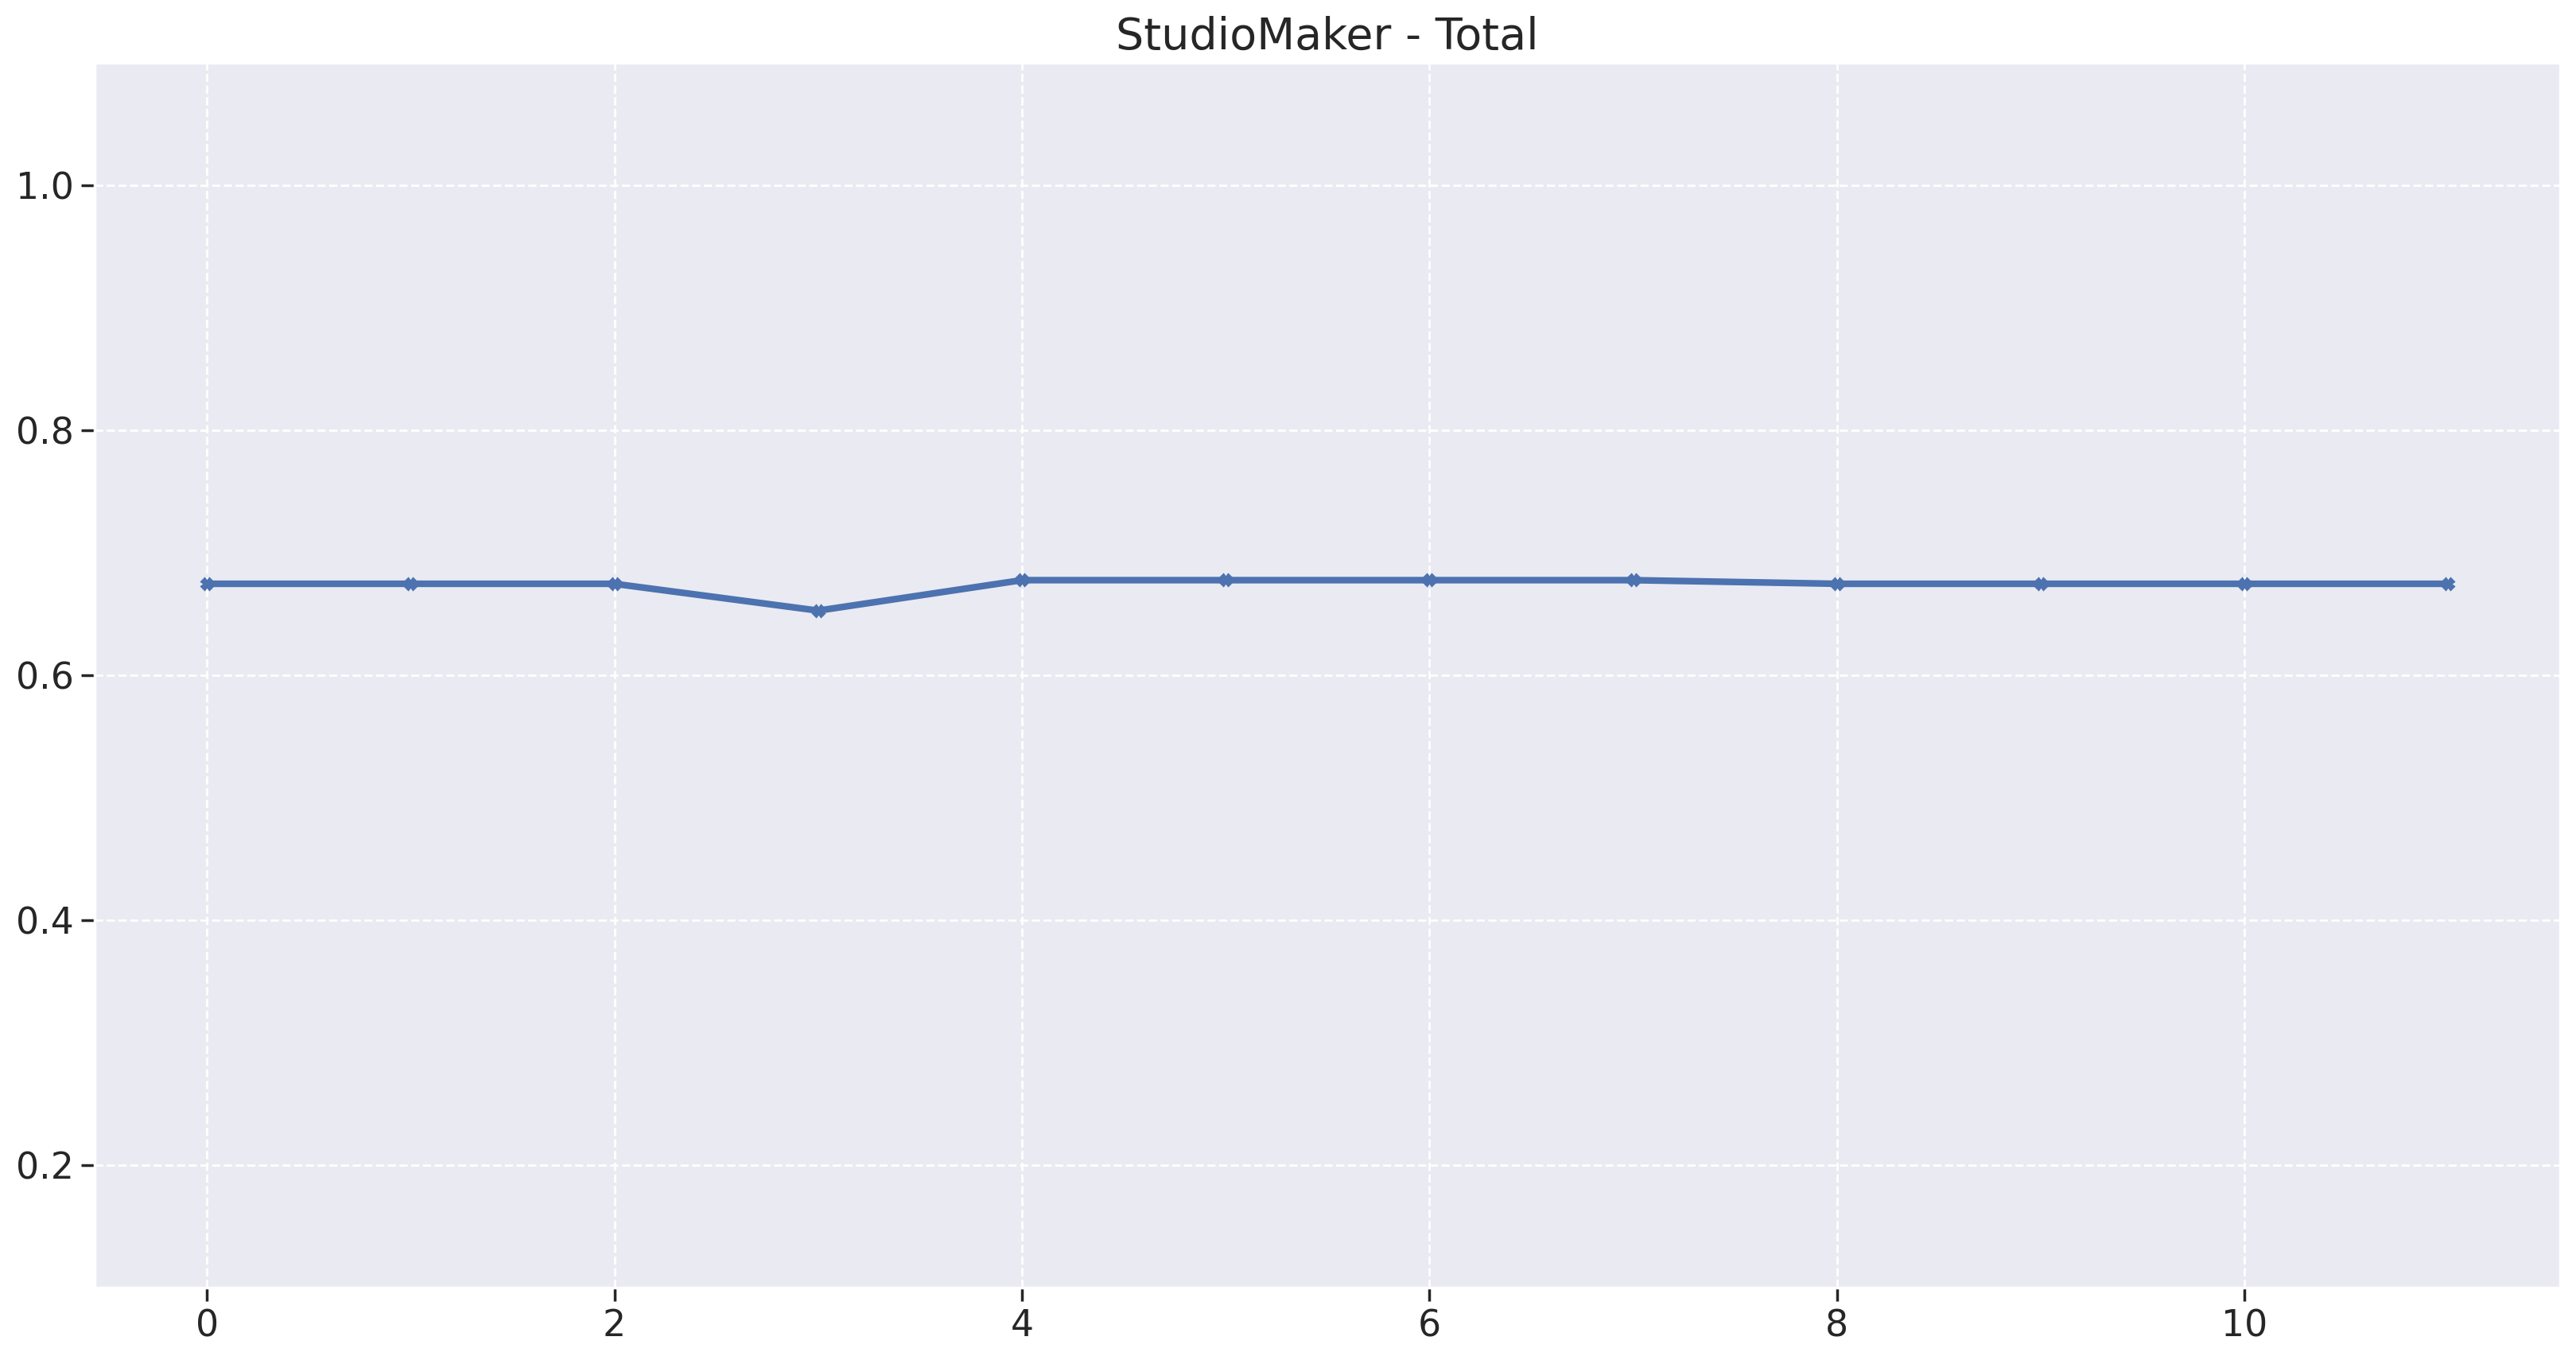

In [31]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

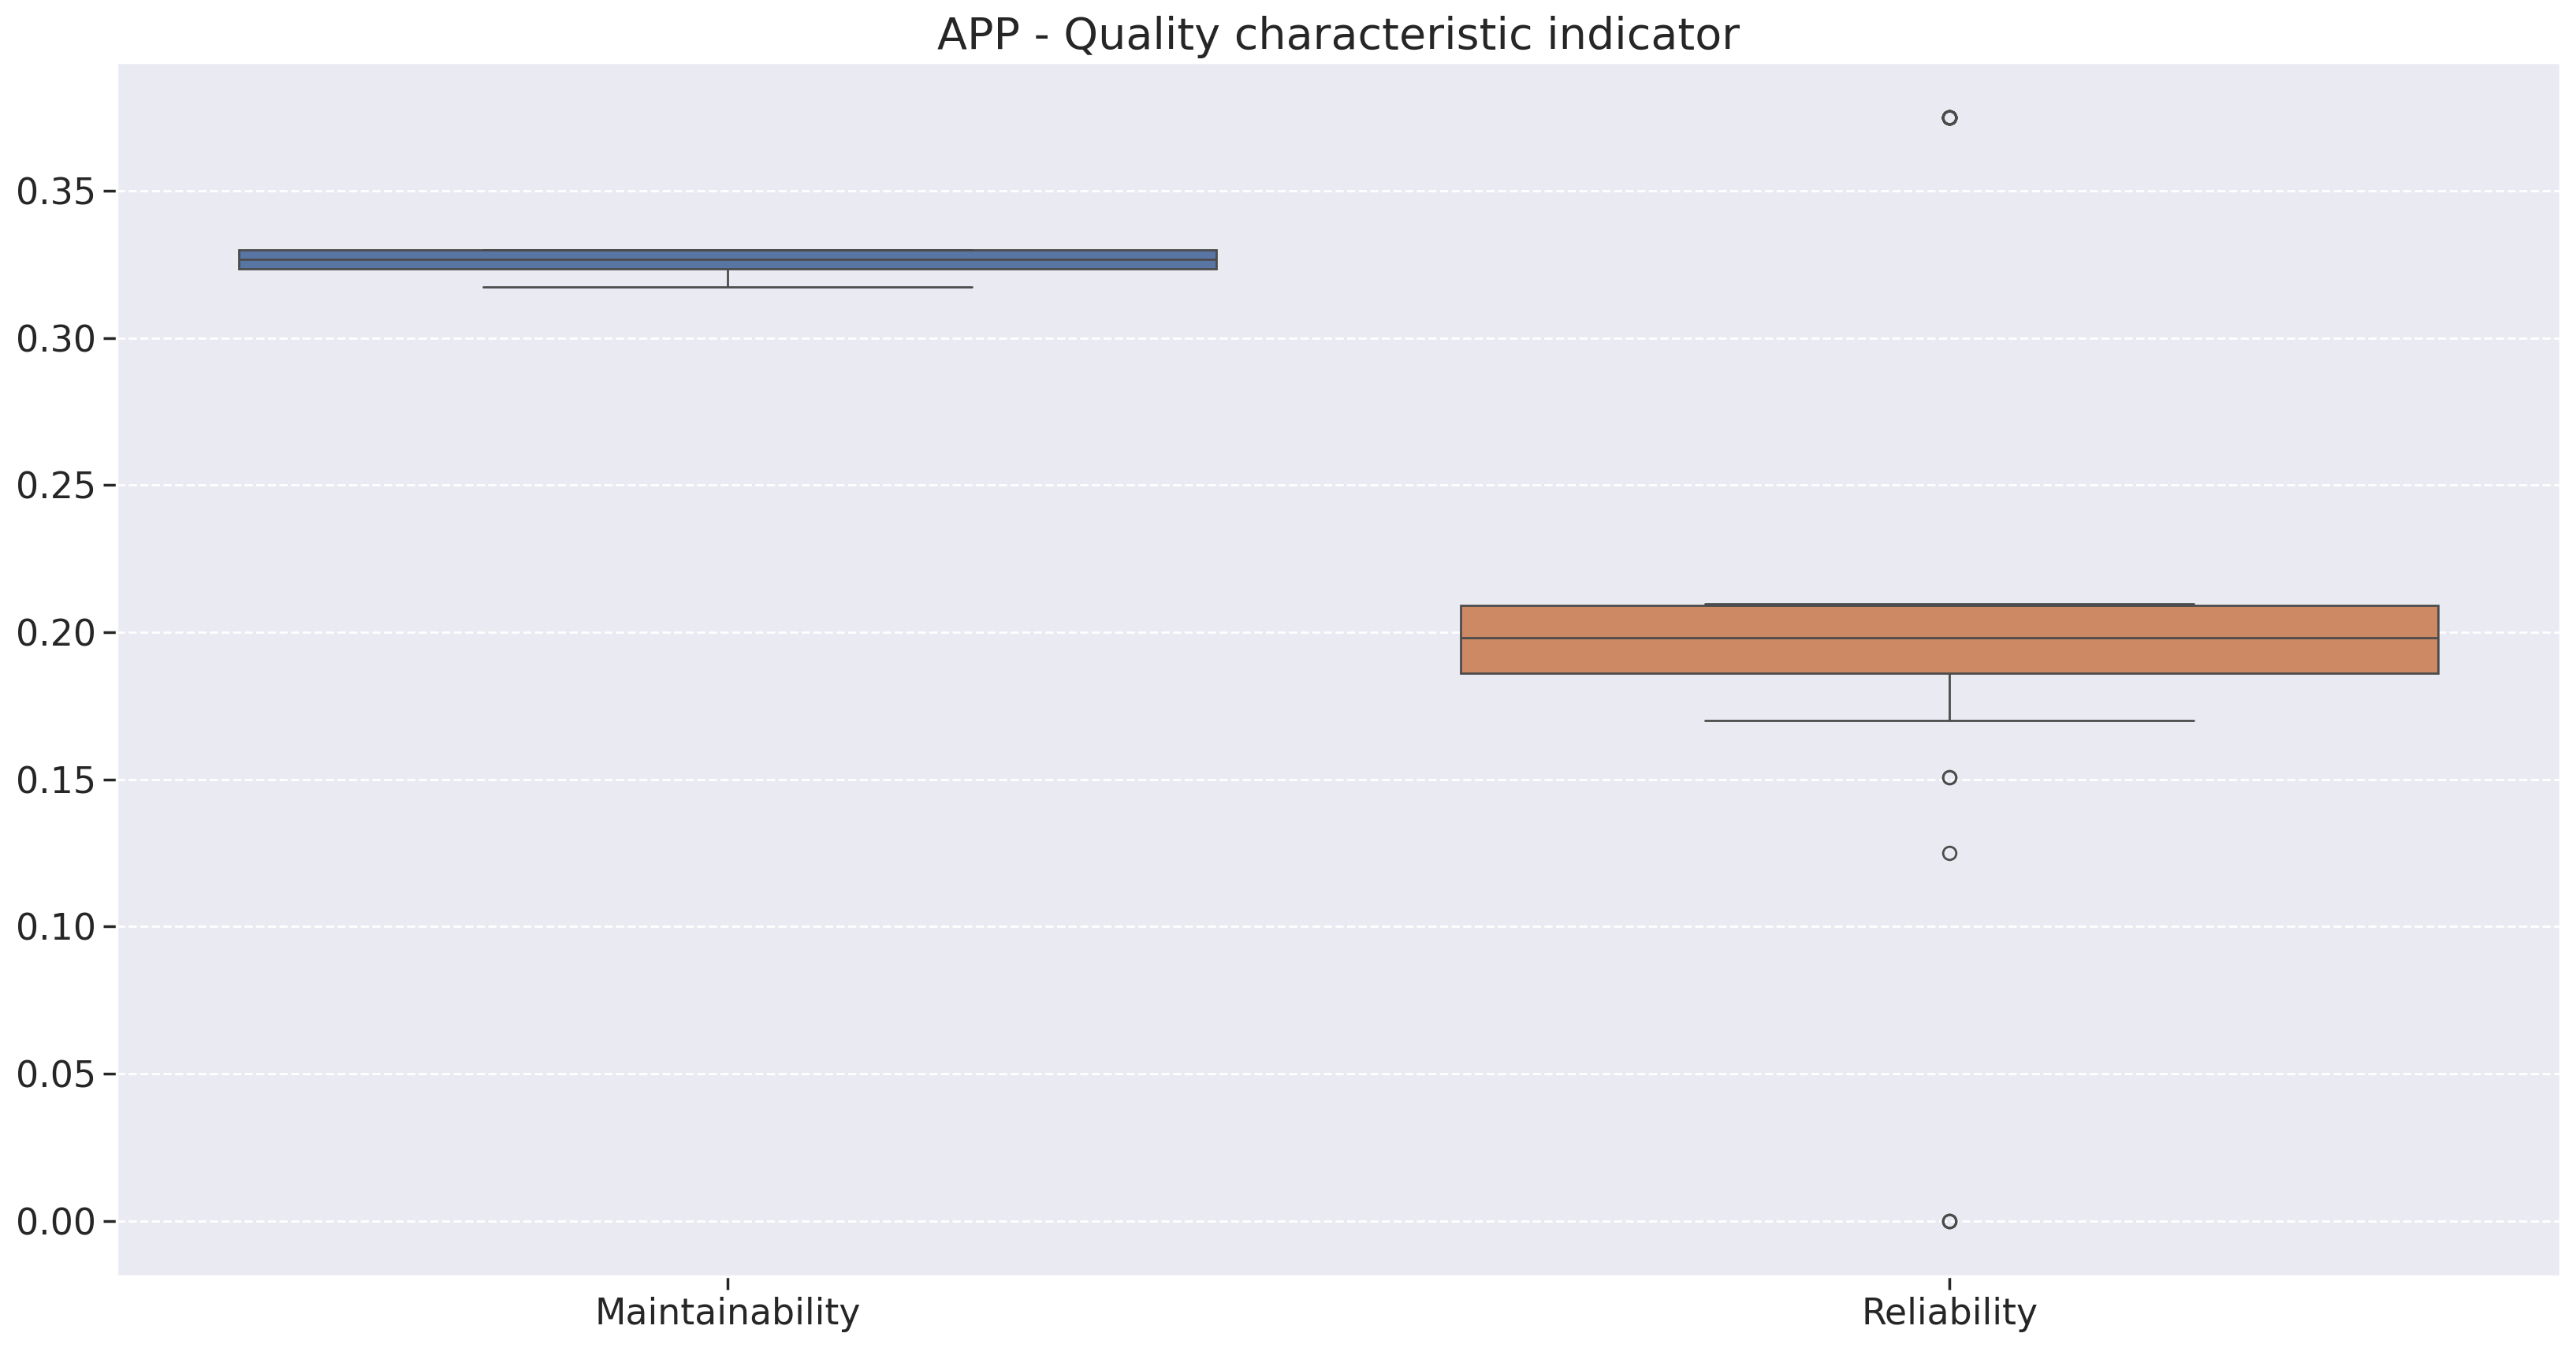

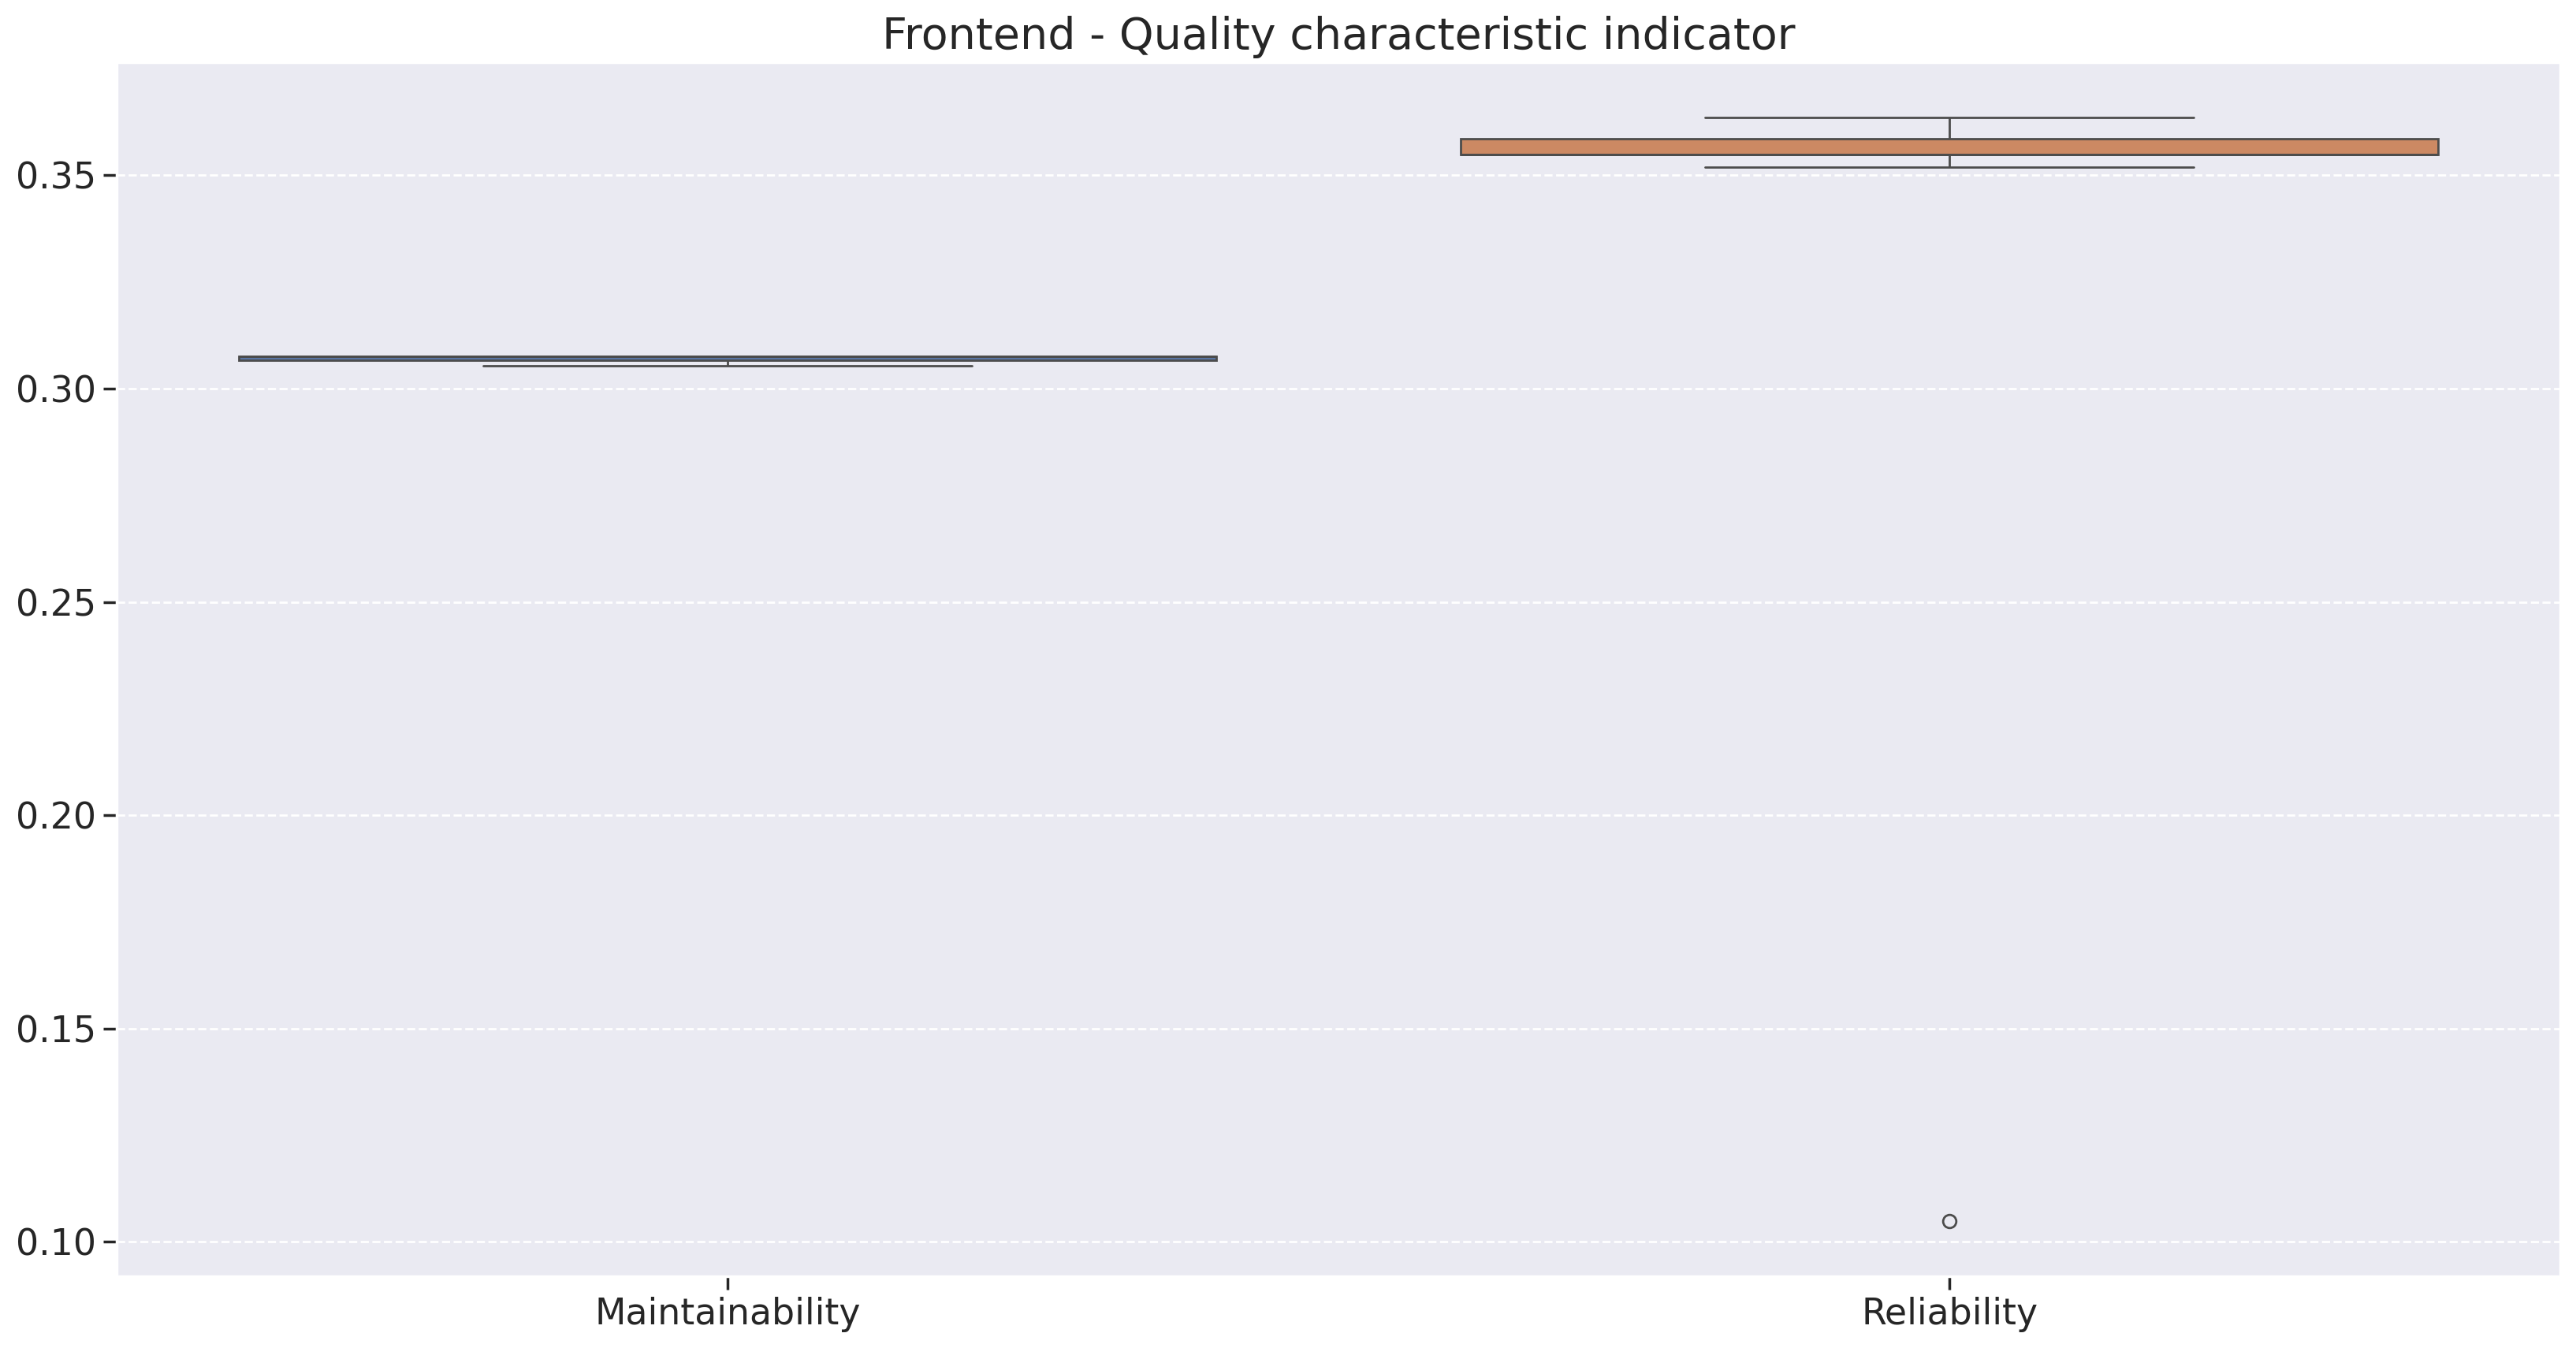

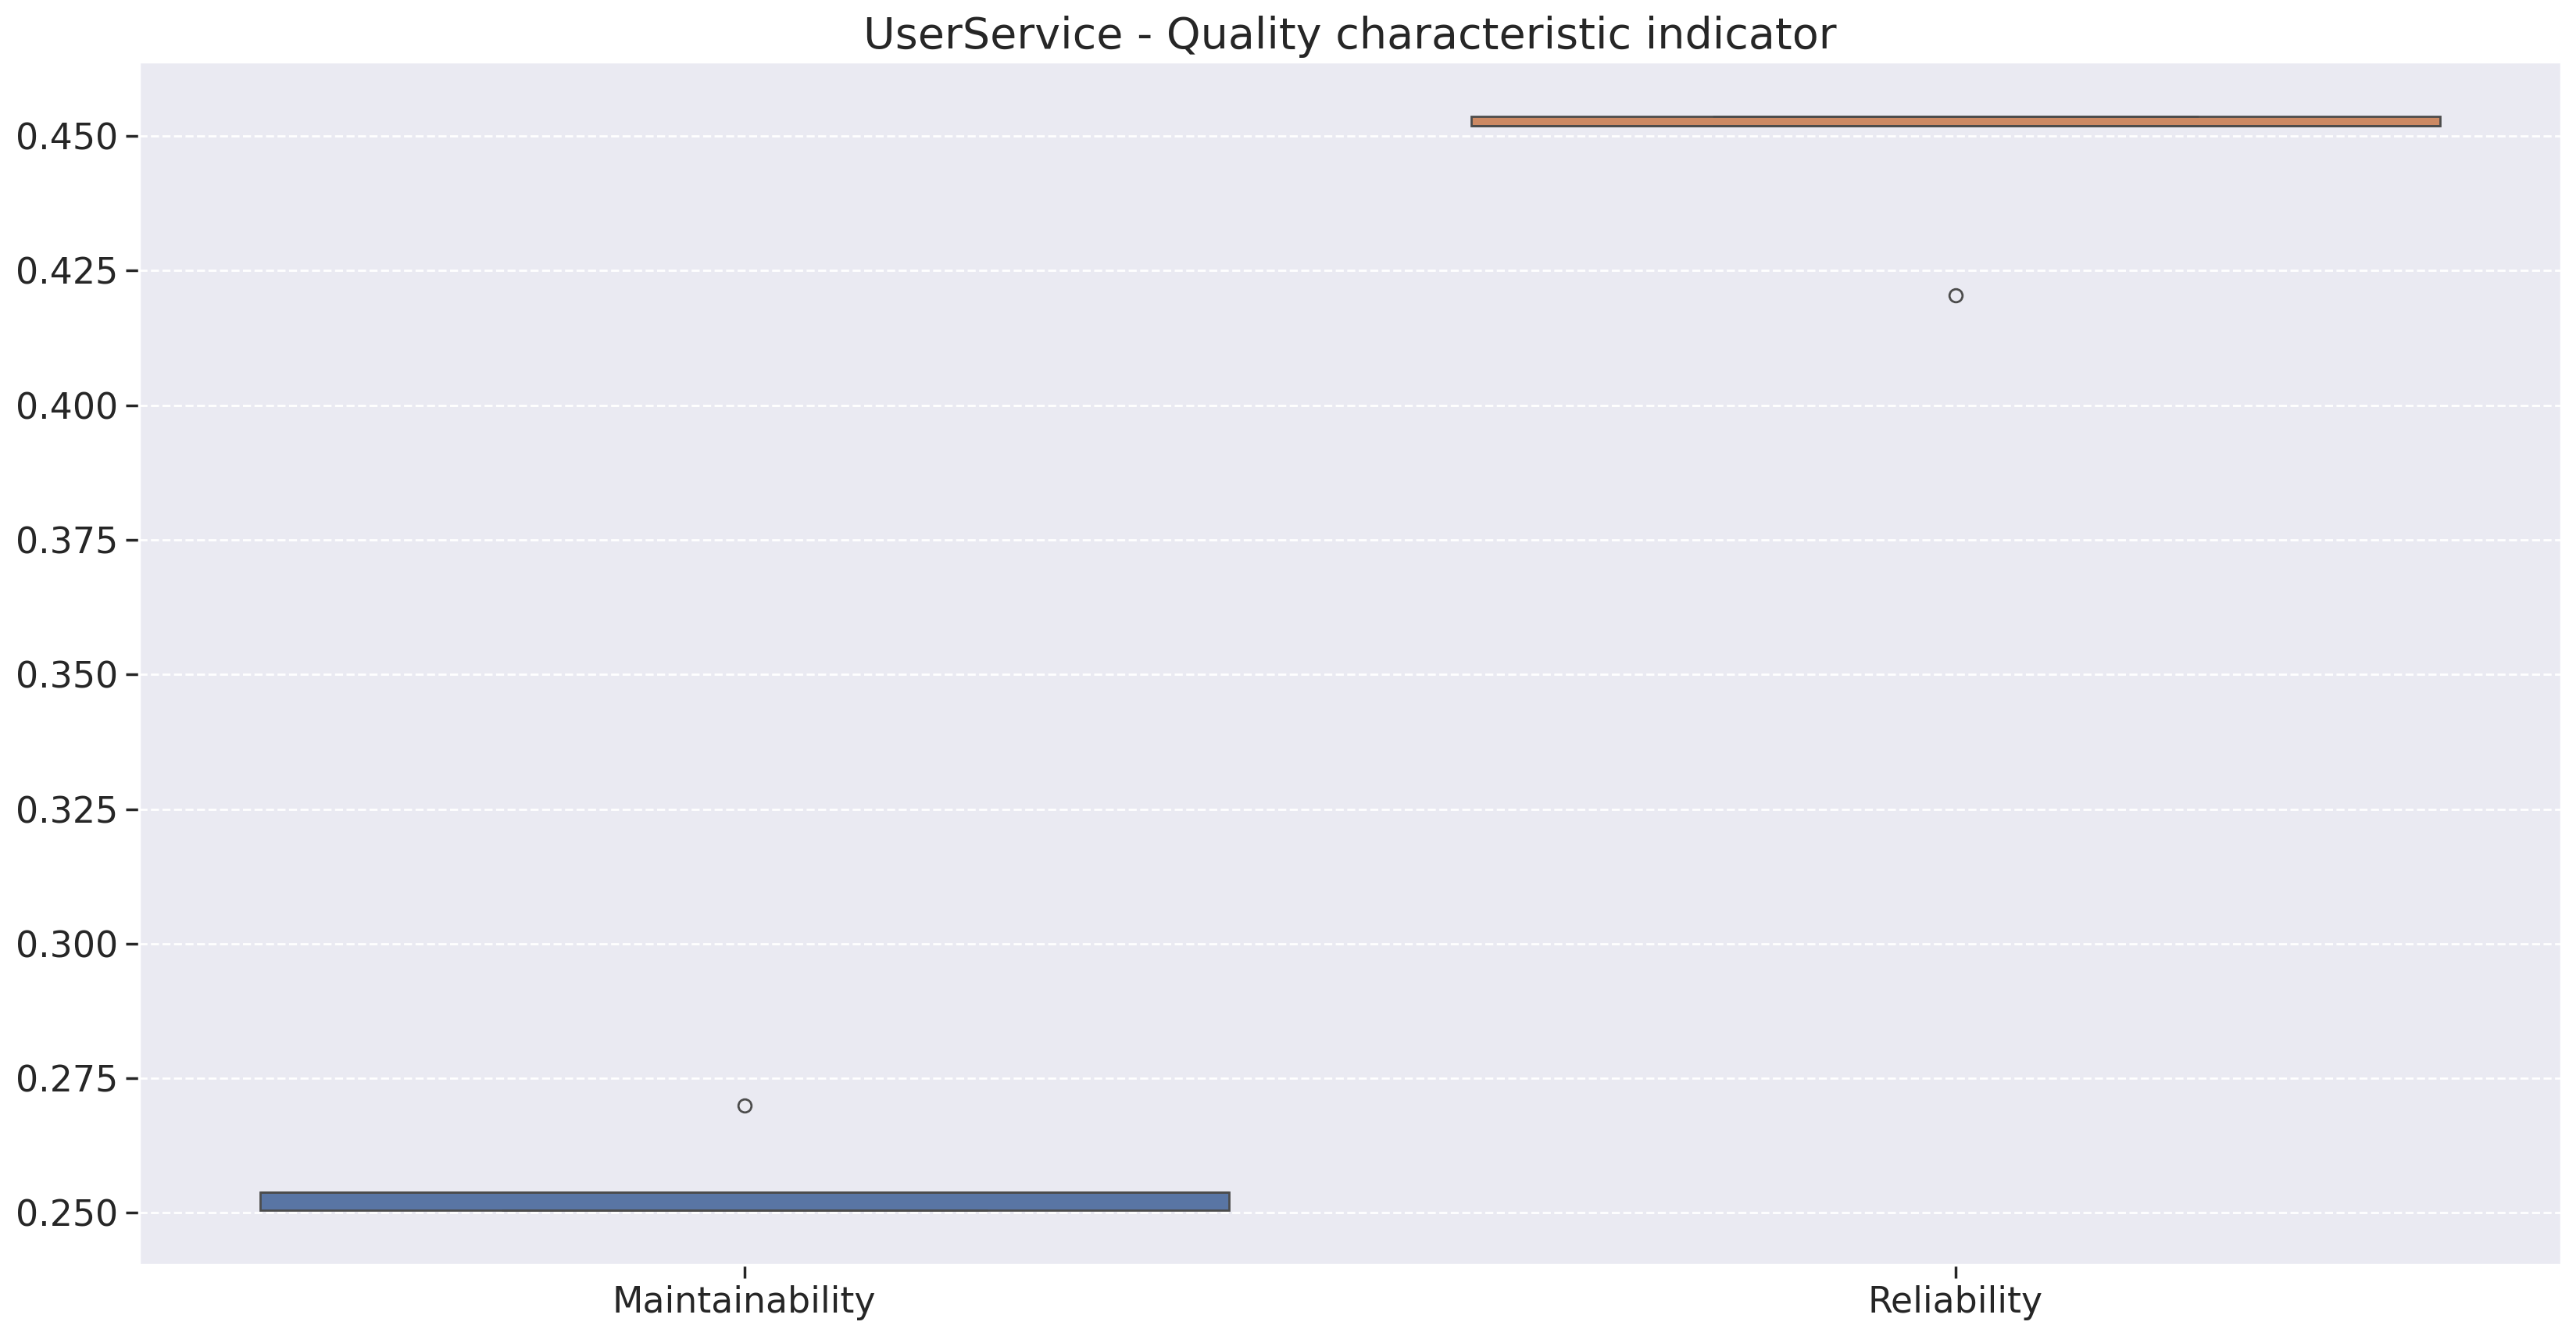

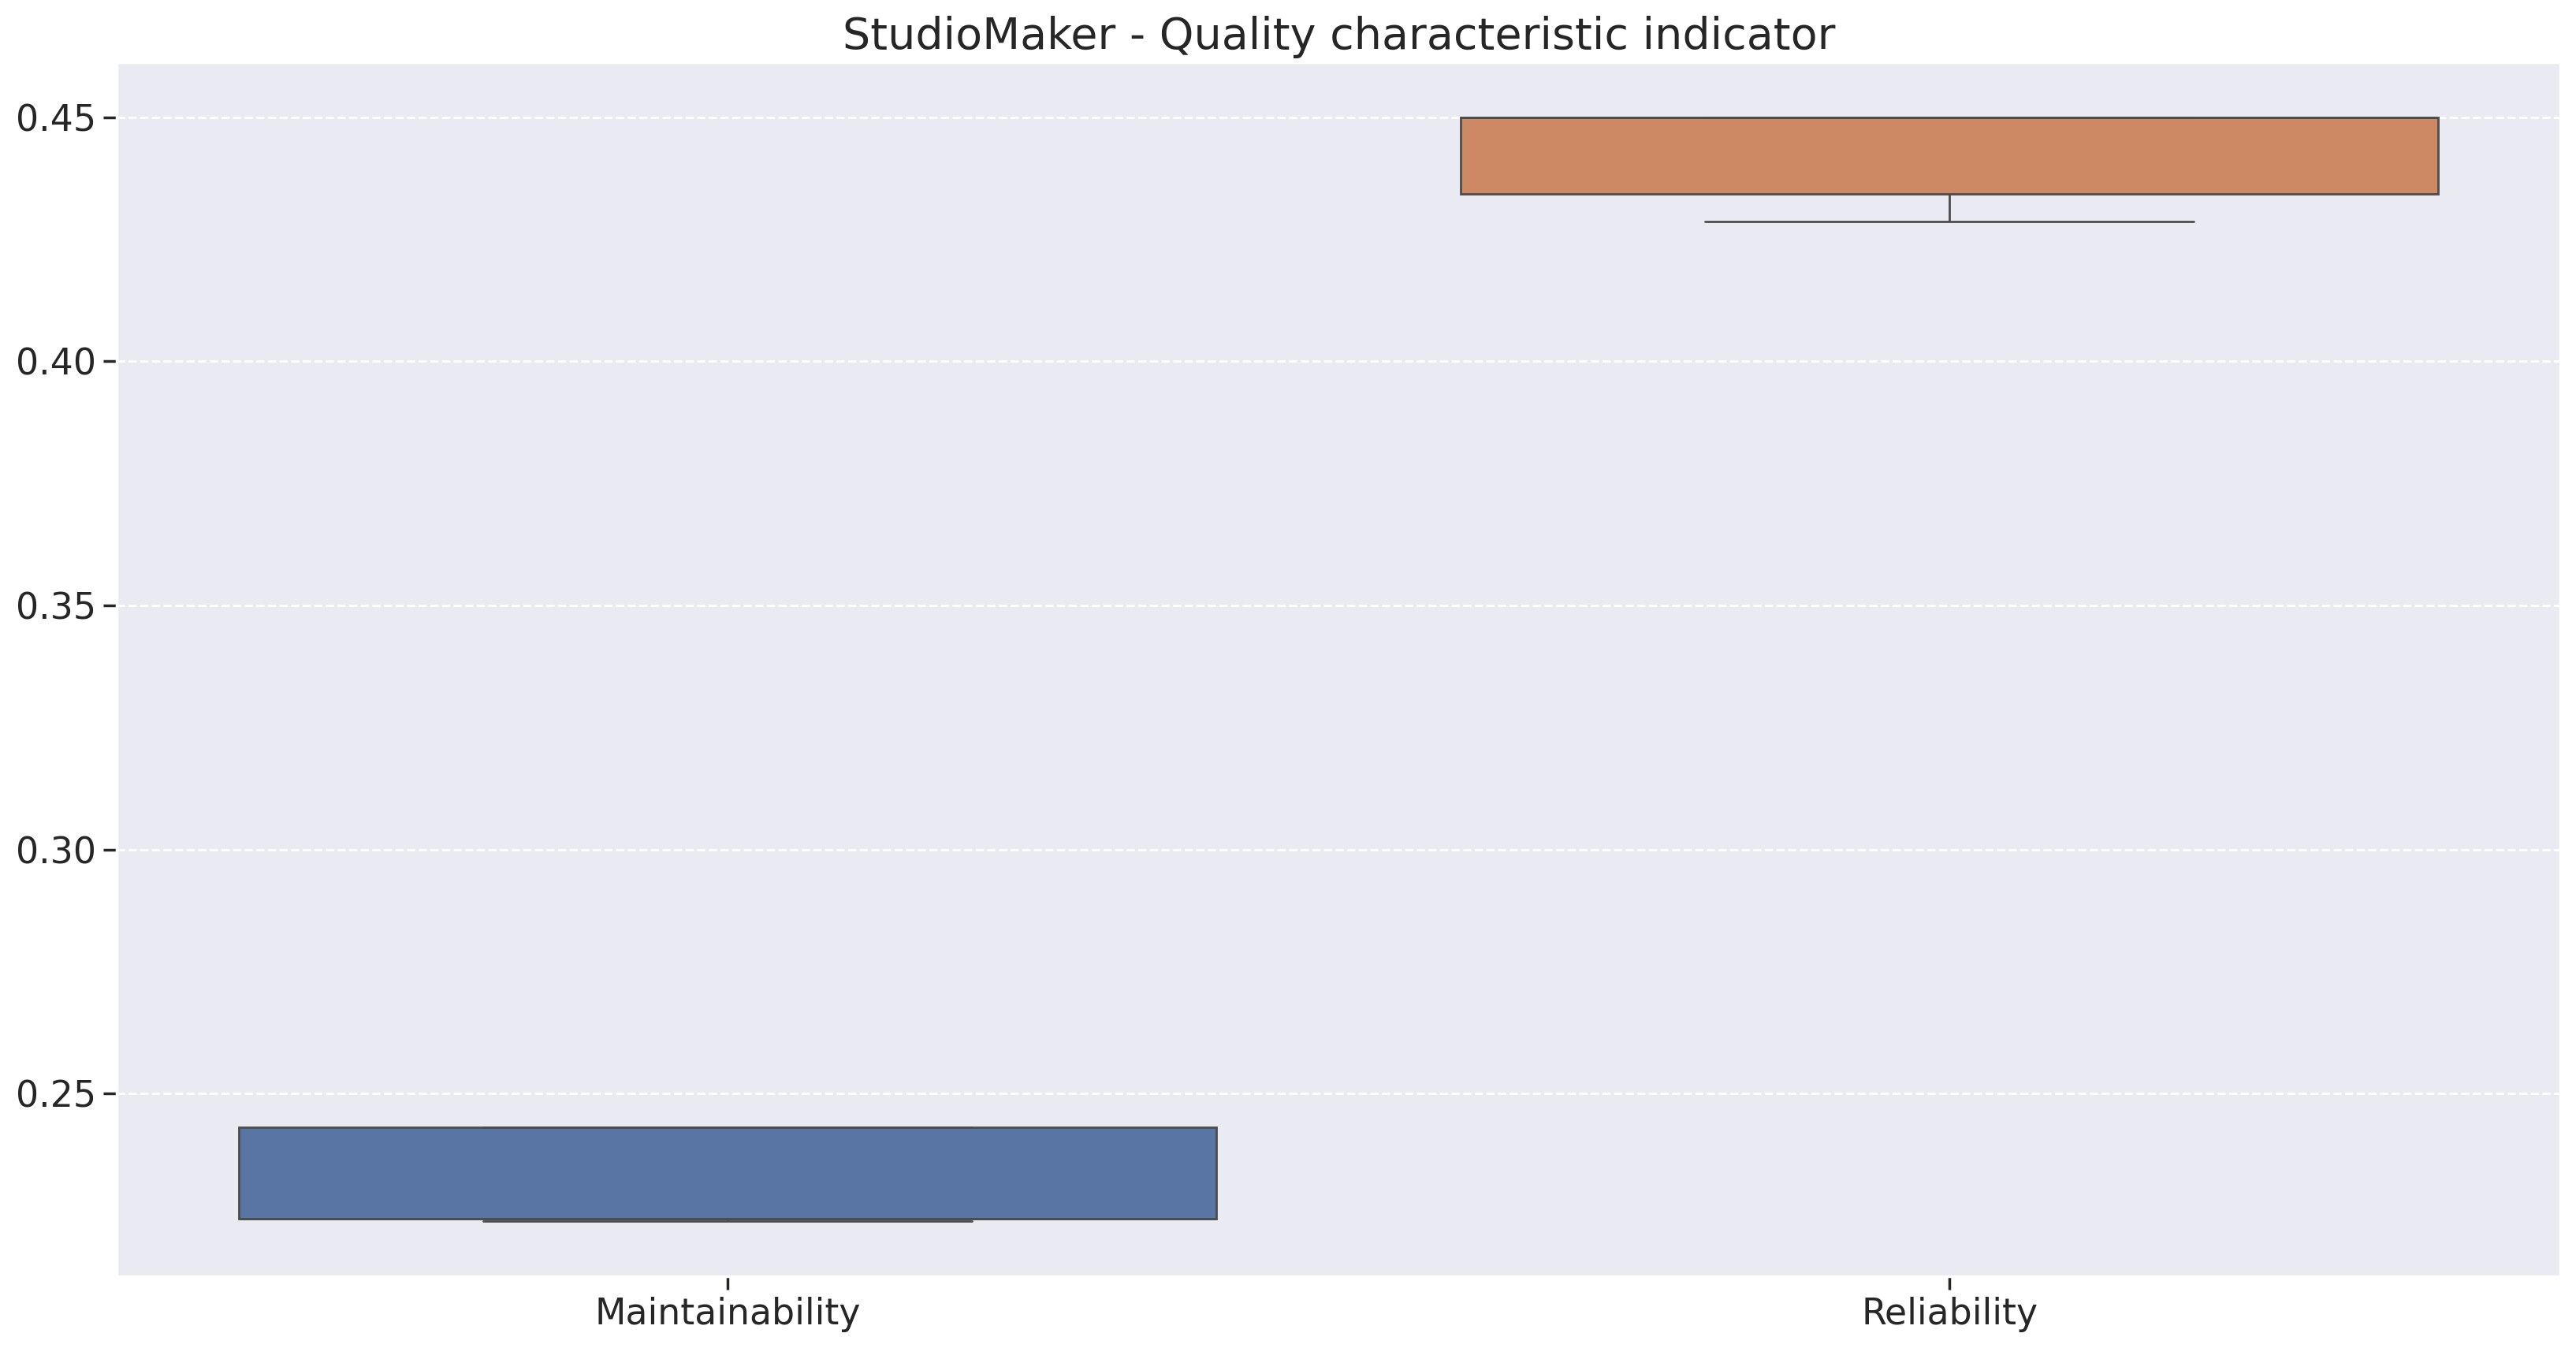

In [32]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

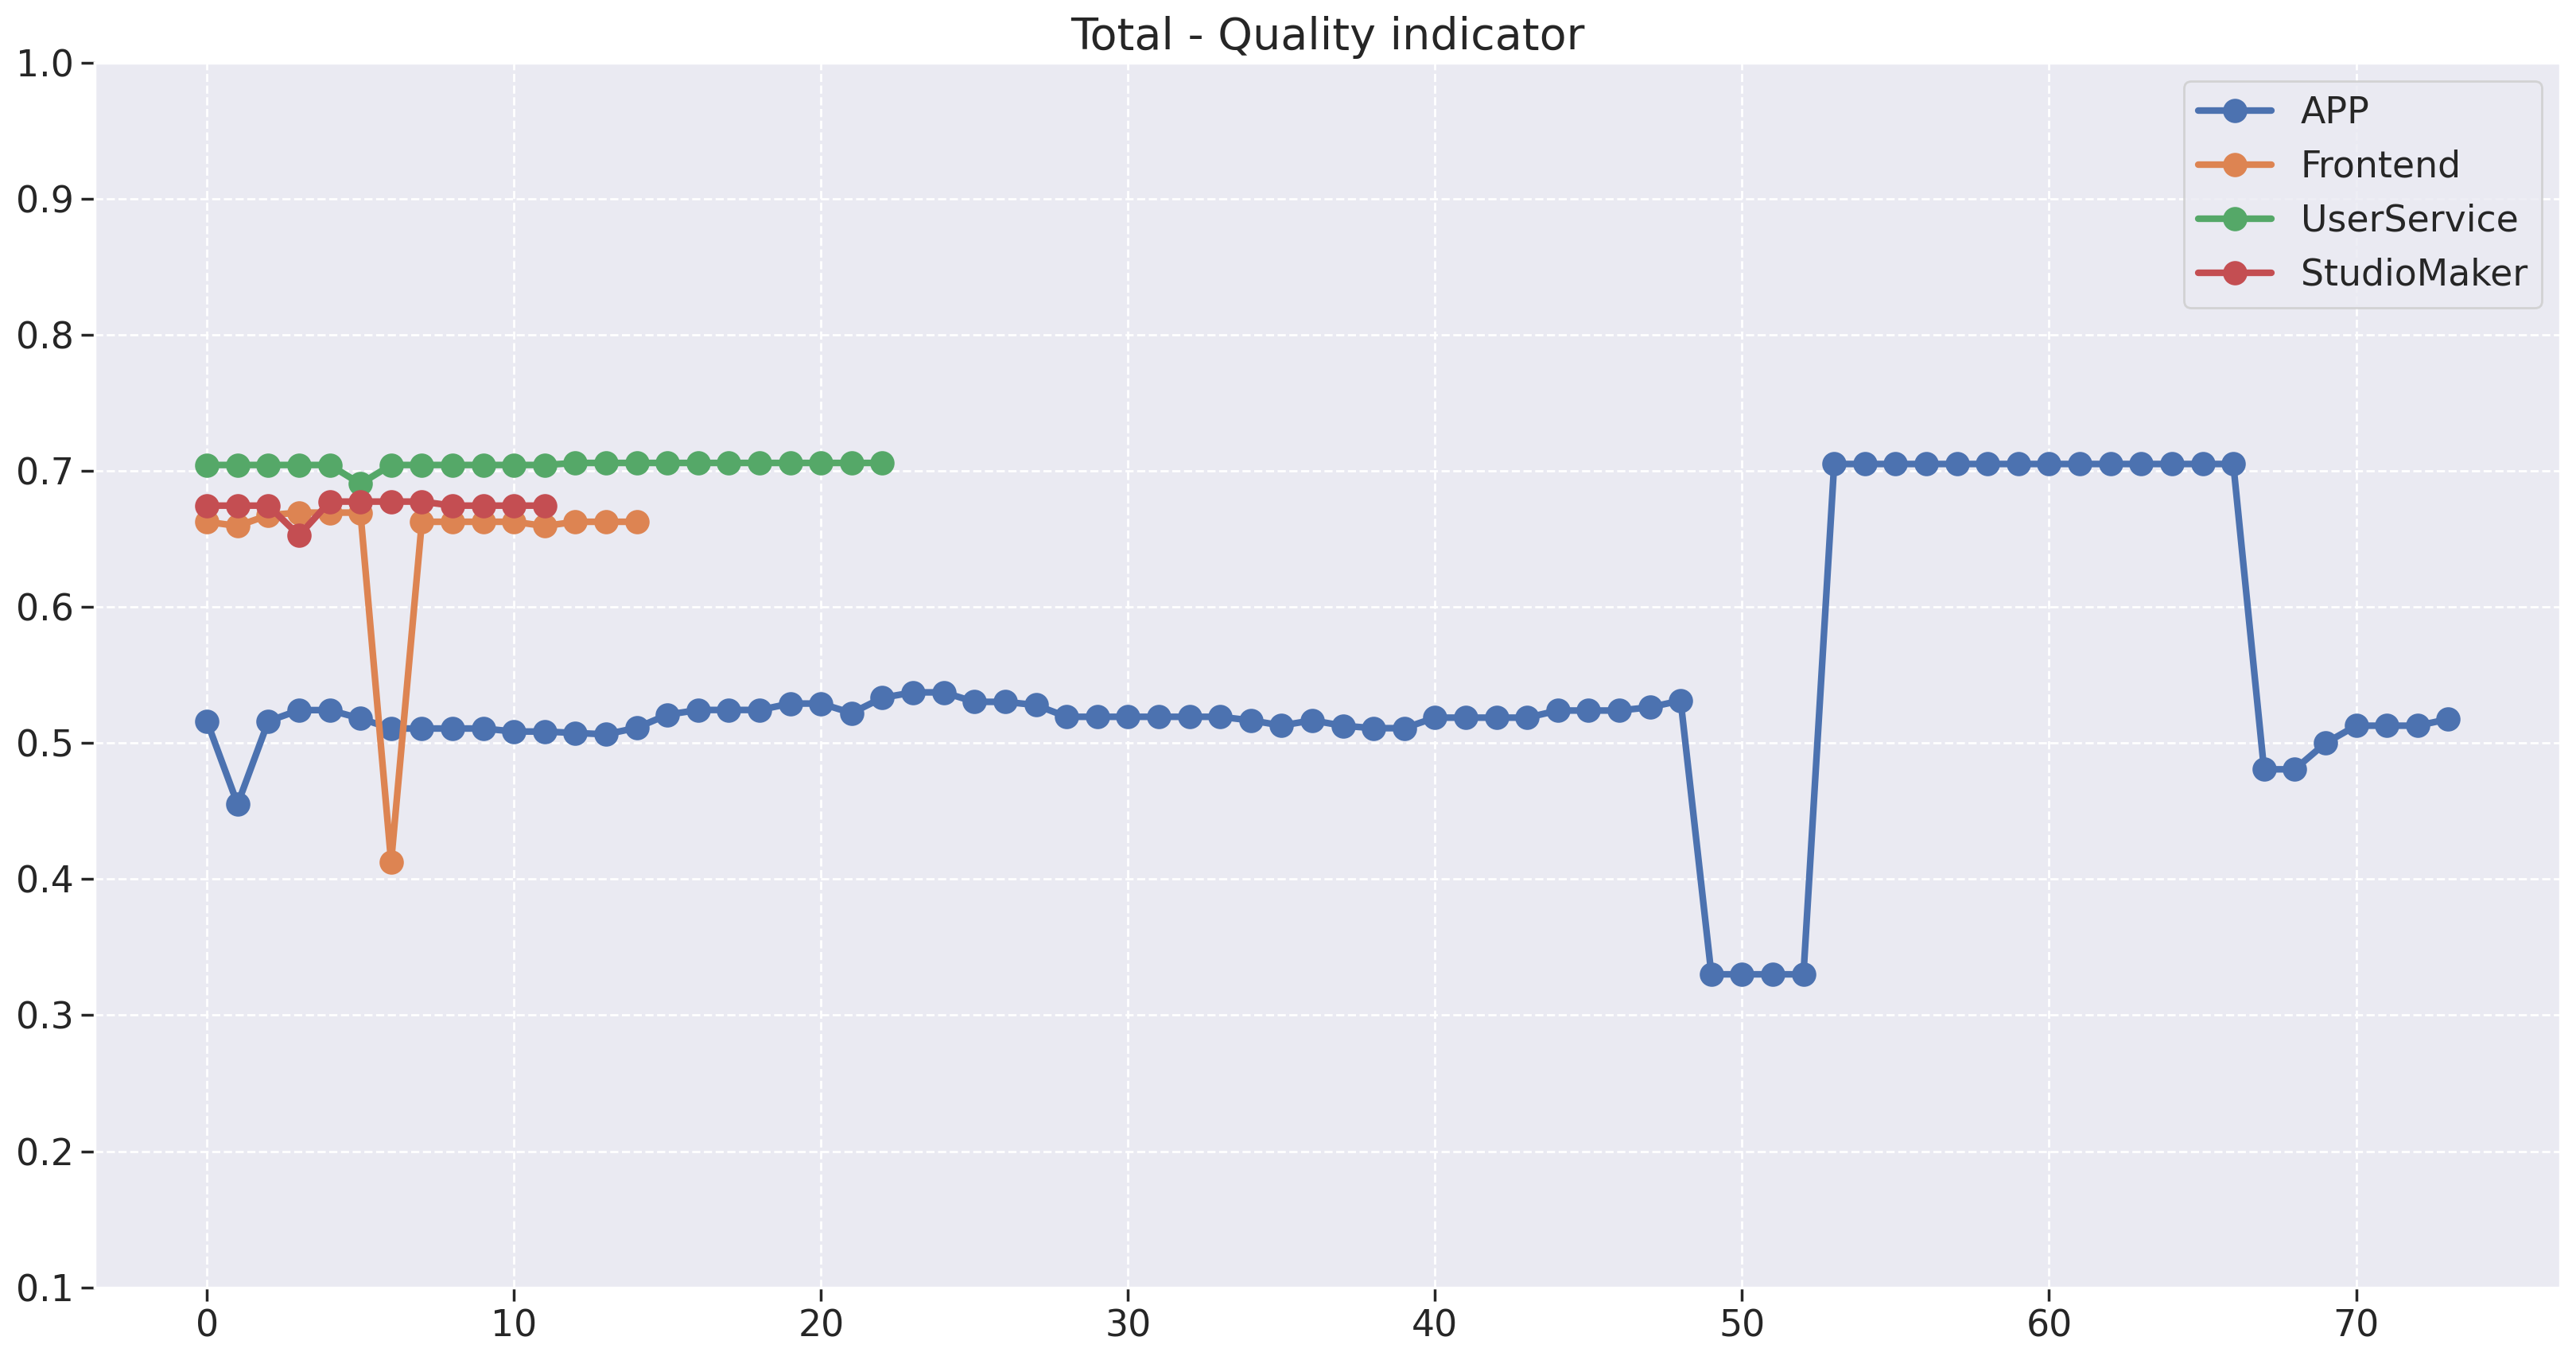

In [33]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [34]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('../data/fga-eps-mds-2024.2-ARANDU--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('../data/fga-eps-mds-2024.2-ARANDU--{}.csv'.format(current_datetime), index = False)

,complexity,comments,duplication,test_success,fast_tests,coverage,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,1.000000,0.048780,0.951220,0.0,1.0,0.243902,fga-eps-mds-2024.2-ARANDU-APP,01-08-2025-23-06-35,8494,0.660000,0.371951,0.330000,0.185976,0.515976
1,1.000000,0.048780,0.951220,0.0,1.0,0.000000,fga-eps-mds-2024.2-ARANDU-APP,01-08-2025-23-48-02,8494,0.660000,0.250000,0.330000,0.125000,0.455000
2,1.000000,0.048780,0.951220,0.0,1.0,0.243902,fga-eps-mds-2024.2-ARANDU-APP,01-10-2025-02-49-42,8494,0.660000,0.371951,0.330000,0.185976,0.515976
3,1.000000,0.024390,0.951220,0.0,1.0,0.292683,fga-eps-mds-2024.2-ARANDU-APP,01-10-2025-03-48-11,8374,0.651951,0.396341,0.325976,0.198171,0.524146
4,1.000000,0.024390,0.951220,0.0,1.0,0.292683,fga-eps-mds-2024.2-ARANDU-APP,01-10-2025-22-49-59,8274,0.651951,0.396341,0.325976,0.198171,0.524146
5,1.000000,0.022222,0.955556,0.0,1.0,0.266667,fga-eps-mds-2024.2-ARANDU-APP,01-10-2025-23-12-12,9605,0.652667,0.383333,0.326333,0.191667,0.518000
6,1.000000,0.041667,0.916667,0.0,1.0,0.250000,fga-eps-mds-2024.2-ARANDU-APP,01-11-2025-01-31-40,10109,0.646250,0.375000,0.323125,0.187500,0.510625
7,1.000000,0.041667,0.916667,0.0,1.0,0.250000,fga-eps-mds-2024.2-ARANDU-APP,01-11-2025-02-16-05,10059,0.646250,0.375000,0.323125,0.187500,0.510625
8,1.000000,0.041667,0.916667,0.0,1.0,0.250000,fga-eps-mds-2024.2-ARANDU-APP,01-11-2025-02-21-05,10059,0.646250,0.375000,0.323125,0.187500,0.510625
9,1.000000,0.041667,0.916667,0.0,1.0,0.250000,fga-eps-mds-2024.2-ARANDU-APP,01-14-2025-21-00-12,10059,0.646250,0.375000,0.323125,0.187500,0.510625
